In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF） の追加ように下記を作成8月２３日
train_df2  = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#行数の表示制限を解除
pd.set_option('display.max_rows', None)
#列数の表示制限を解除
pd.set_option('display.max_columns', None)
#表示が膨大になるので、必ず head()を設定すること。
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 0 目的変数の分布図を確認して、正規分布によっているかどうか対数変換などで整形はいるか？ などを判断

Text(0, 0.5, '度数')

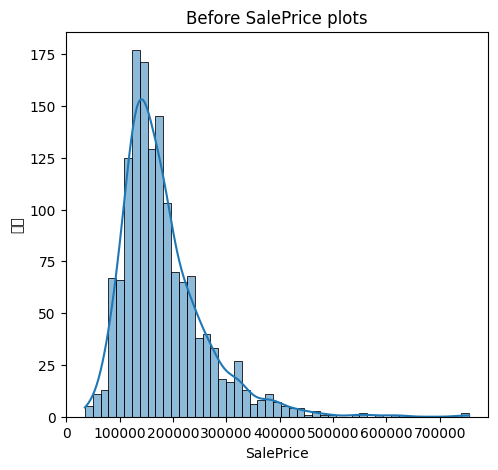

In [3]:
plt.figure(figsize=(12, 5))

# 左側のプロット：変換前のヒストグラム
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Before SalePrice plots')
plt.xlabel('SalePrice')
plt.ylabel('度数')

## train_df SalePrice の対数変換前のバックアップ

In [4]:
#実践的な判断フロー
#計算: 特徴量の歪度を計算する (.skew())。
#閾値チェック: 絶対値が 0.5 や 1.0 を超えているか確認する。
#性質チェック: それは変換可能な「連続値」か？ (OverallQual のようなものではないか？)
#可視化: ヒストグラムで分布の形を目で見て確認する。
#実験: 変換した場合としない場合で、モデルの精度を比較してみる。
#この多角的な視点を持つことが、より精度の高いモデルを作成するための鍵となります。

In [5]:
#明確な黄金律（ゴールデンルール）はありませんが、データサイエンスの実務でよく用いられる経験則としての一般的な目安は以下の通りです。
#歪度の目安と対数変換の判断基準
#歪度は、正負両方の値を取りうるため、絶対値で判断するのが一般的です。
#| 歪度の絶対値 (|skew|) | 評価 | 対数変換の必要性 |
#| :--- | :--- | :--- |
#| 0.5 以下 | ほぼ対称 (Approximately Symmetric) | 原則として不要です。変換による改善効果はほとんど期待できません。 |
#| 0.5 ～ 1.0 | 中程度に歪んでいる (Moderately Skewed) | 検討の価値あり。変換によってモデルの性能が向上する可能性があります。特に線形モデルを使う場合は有効なことが多いです。 |
#| 1.0 より大きい | 強く歪んでいる (Highly Skewed) | 強く推奨されます。変換しないと、外れ値の影響を強く受けたり、モデルの仮定（正規性など）から外れたりして、精度が悪化する可能性が高いです。 |
#Kaggleの住宅価格データ（train.csv）で例を見てみましょう。
#SalePrice の歪度: 約 1.88
#これは 1.0 を大幅に超えており、「強く歪んでいる」に該当します。そのため、対数変換やYeo-Johnson変換が非常に効果的です。
#GrLivArea の歪度: 約 1.37
#これも 1.0 を超えているため、変換の対象として有力な候補となります。
#OverallQual の歪度: 約 -0.22
#絶対値が 0.5 以下なので、「ほぼ対称」と判断できます。この数値からも、この特徴量に歪み補正は不要であることがわかります。

In [6]:
#結果の表示と解釈: 計算した歪度の値を表示し、その値が一般的にどのように解釈されるかの目安も表示するようにしました。
#歪度が0に近い: 分布が左右対称（正規分布など）に近いことを意味します。
#歪度が正の値: 分布の山が左に寄り、右側に裾が長く伸びている（右に歪んだ）分布です。平均値が中央値よりも大きくなる傾向があります。SalePrice はこの典型例です。
#歪度が負の値: 分布の山が右に寄り、左側に裾が長く伸びている（左に歪んだ）分布です。

# --- 1. 'OverallQual' の歪度を計算 ---
skewness = train_df['SalePrice'].skew()


# --- 2. 結果の表示 ---
print(f" SalePriceの歪度: {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。")

 SalePriceの歪度: 1.8829
-----------------------------------------
【歪度の目安】
 -> 右に裾が長い（右に歪んだ）分布です。


In [7]:
#1460ID（行）と、81カラム（列）とわかる。
train_df.shape

(1460, 81)

In [8]:
#1460IDの（行）が、1460とわかる。
len(train_df)

1460

In [9]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


### 見かけだけでカラムのデータを判断しないように、まずはカラムの種類を調べる

In [10]:
#データフレームの中身の種類を確認するときは、必ずすべてを確認するために、
#行数の表示制限を解除　pd.set_option('display.max_rows', None)
#列数の表示制限を解除　pd.set_option('display.max_columns', None)
#の表示制限解除が必要となる場合がある。

## 欠損値の確認

In [11]:
#ベースライン用に、まずは欠損値がないものを探す。
print(train_df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

## 特徴量のデータ型の確認

In [12]:
#欠損値がないかつカラムのデータ型を確認する。（RMSEの場合、object型は扱えない)
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


## 学習用データ全体とテストデータ全体のバックアップ

In [13]:
#testデータの読み込みと。ID数とカラム数を表示をさせている
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
#TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF） の追加用で下記を作成した。
test2 = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test.shape

(1459, 80)

In [14]:
train_df_backup = train_df.copy()
test_backup = test.copy()

## 特徴量の選択

In [15]:
#以下、あたりをつけた特徴量
features=["SaleCondition", "FullBath", "SaleType", "Functional", "MSZoning", "Neighborhood", "LotArea", "MSSubClass", "TotRmsAbvGrd", "GrLivArea", "1stFlrSF", "OverallQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "HeatingQC", "CentralAir", "KitchenAbvGr", "KitchenQual", "ExterQual", "GarageCars", "GarageArea", "OverallCond"]
#目的変数y_train と説明変数x_trainに分けた。ここは、まだベースラインなのでドメイン知識と欠損値がないという理由だけの説明変数の選択。
x_train = train_df[features]
y_train = train_df["SalePrice"]

print(x_train.shape)
print(y_train.shape)

(1460, 25)
(1460,)


### featuresのバックアップ

In [16]:
# featuresのバックアップOverallQualの追加とHeatingの削除
#↓
#features_back_up_0810 = features 
#FullBath の追加
#↓
#features_back_up_0812 = features

#YearBuilt、YrSold の追加
#↓
#features_back_up_0813 = features

In [17]:
features

['SaleCondition',
 'FullBath',
 'SaleType',
 'Functional',
 'MSZoning',
 'Neighborhood',
 'LotArea',
 'MSSubClass',
 'TotRmsAbvGrd',
 'GrLivArea',
 '1stFlrSF',
 'OverallQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'HeatingQC',
 'CentralAir',
 'KitchenAbvGr',
 'KitchenQual',
 'ExterQual',
 'GarageCars',
 'GarageArea',
 'OverallCond']

## 特徴量選択後のテストデータの定義

In [18]:
#X_test を事前に読み込んだ特徴量の数（features)と設定し、表示させている。

x_test = test[features]
x_test.shape

(1459, 25)

## 特徴量選択後の学習用データとテストデータのバックアップ

In [19]:
x_train_backup = x_train.copy()

In [20]:
x_test_backup = x_test.copy()

## 特徴量 の順序付きマッピング ＠＠最初に欠損値と種類はデータフレームを作成して一覧できる！とにかく時間を短縮できそうならする！

#### 特徴量選択後の学習用データの欠損値を調べる。

In [21]:
#データフレームで、選択した特徴量の欠損件数等をあらかじめ表示させる

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


#### 特徴量選択後のテストデータの欠損値を調べる。（欠損値への処理は学習用、テスト用ともに必要なので、かならずどちらも欠損値を確認する）

In [22]:
missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


#### 選択した特徴量の種類とそのサンプル値を確認する。（学習用データ）

In [23]:
#pandas のデフォルト表示幅制限を解除↓

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

    
with pd.option_context('display.max_colwidth', None):
    display(summary)



,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


#### 選択した特徴量の種類とそのサンプル値を確認する。（テストデータ）

In [24]:
#pandas のデフォルト表示幅制限を解除↓
summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
}, index=features)

with pd.option_context('display.max_colwidth', None):
    display(summary)


summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


#### Heating QC のマッピング

In [25]:
##学習用データの型と値の種類を確認する
print(x_train['HeatingQC'].dtype)
print(x_train['HeatingQC'].unique())

object
['Ex' 'Gd' 'TA' 'Fa' 'Po']


In [26]:
#テスト用データの型と値の種類を確認する
print(x_test['HeatingQC'].dtype)
print(x_test['HeatingQC'].unique())

object
['TA' 'Gd' 'Ex' 'Fa' 'Po']


In [27]:
heatingQC_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['HeatingQC'] = x_train['HeatingQC'].map(heatingQC_order)
x_test['HeatingQC'] = x_test['HeatingQC'].map(heatingQC_order)

In [28]:
missing_count = x_train['HeatingQC'].isna().sum()
print(f"'HeatingQC' の欠損値件数: {missing_count} 件")

'HeatingQC' の欠損値件数: 0 件


In [29]:
missing_count = x_test['HeatingQC'].isna().sum()
print(f"'HeatingQC' の欠損値件数: {missing_count} 件")

'HeatingQC' の欠損値件数: 0 件


#### CentralAir	のマッピング

In [30]:
##学習用データの型と値の種類を確認する
print(x_train['CentralAir'].dtype)
print(x_train['CentralAir'].unique())

object
['Y' 'N']


In [31]:
##テスト用データの型と値の種類を確認する
print(x_test['CentralAir'].dtype)
print(x_test['CentralAir'].unique())

object
['Y' 'N']


In [32]:
CentralAir_order = {
    'Y': 1,
    'N': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['CentralAir'] = x_train['CentralAir'].map(CentralAir_order)
x_test['CentralAir'] = x_test['CentralAir'].map(CentralAir_order)

In [33]:
missing_count = x_train['CentralAir'].isna().sum()
print(f"'CentralAir' の欠損値件数: {missing_count} 件")

'CentralAir' の欠損値件数: 0 件


In [34]:
missing_count = x_test['CentralAir'].isna().sum()
print(f"'CentralAir' の欠損値件数: {missing_count} 件")

'CentralAir' の欠損値件数: 0 件


#### Heating,Heating QC ,CentralAir のマッピング後のバックアップ(0709)

In [35]:
x_train_backup0709 = x_train.copy()
x_test_backup0709 = x_test.copy()

#### BsmtCondのマッピング（欠損値 train,test ともに欠損値あり）欠損値を補完したあとでないと、型の変換はできない

In [36]:
##学習用データの型と値の種類を確認する
print(x_train['BsmtCond'].dtype)
print(x_train['BsmtCond'].unique())

object
['TA' 'Gd' nan 'Fa' 'Po']


In [37]:
##テスト用データの型と値の種類を確認する
print(x_test['BsmtCond'].dtype)
print(x_test['BsmtCond'].unique())

object
['TA' 'Po' 'Fa' 'Gd' nan]


In [38]:
#BsmtCond
#[TA, Po, Fa, Gd]

BsmtCond_order = {
    'Gd': 3,
    'TA': 2,
    'Fa': 1,  
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtCond'] = x_train['BsmtCond'].map(BsmtCond_order)
x_test['BsmtCond'] = x_test['BsmtCond'].map(BsmtCond_order)

In [39]:
missing_count = x_train['BsmtCond'].isna().sum()
print(f"'BsmtCond' の欠損値件数: {missing_count} 件")

'BsmtCond' の欠損値件数: 37 件


In [40]:
missing_count = x_test['BsmtCond'].isna().sum()
print(f"'BsmtCond' の欠損値件数: {missing_count} 件")

'BsmtCond' の欠損値件数: 45 件


#### Heating,Heating QC,CentralAir,BsmtCond のマッピング後のバックアップ(0709_1)¶

In [41]:
x_train_backup0709_1 = x_train.copy()
x_test_backup0709_1 = x_test.copy()

#### KitchenAbvGrのマッピングint 型なので、キーとマップをintでそろえること

In [42]:
###学習用データの型と値の種類を確認する
print(x_train['KitchenAbvGr'].dtype)
print(x_train['KitchenAbvGr'].unique())

int64
[1 2 3 0]


In [43]:
###テスト用データの型と値の種類を確認する
print(x_test['KitchenAbvGr'].dtype)
print(x_test['KitchenAbvGr'].unique())

int64
[1 2 0]


In [44]:
KitchenAbvGr_order = {
     1: '2',
     2: '1',
     3: '1',  
     0: '0',
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].map(KitchenAbvGr_order)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].map(KitchenAbvGr_order)

In [45]:
missing_count = x_train['KitchenAbvGr'].isna().sum()
print(f"'KitchenAbvGr' の欠損値件数: {missing_count} 件")

'KitchenAbvGr' の欠損値件数: 0 件


In [46]:
missing_count = x_test['KitchenAbvGr'].isna().sum()
print(f"'KitchenAbvGr' の欠損値件数: {missing_count} 件")

'KitchenAbvGr' の欠損値件数: 0 件


In [47]:
#int へ戻した。
x_train['KitchenAbvGr'] = x_train['KitchenAbvGr'].astype(int)
x_test['KitchenAbvGr'] = x_test['KitchenAbvGr'].astype(int)

#### Heating, Heating QC, CentralAir, BsmtCond, KitchenAbvGr のマッピング後のバックアップ(0710)¶

In [48]:
x_train_backup0710 = x_train.copy()
x_test_backup0710 = x_test.copy()

#### KitchenQualのマッピング (欠損値TESTデータに１あり）

In [49]:
###学習用データの型と値の種類を確認する
print(x_train['KitchenQual'].dtype)
print(x_train['KitchenQual'].unique())

object
['Gd' 'TA' 'Ex' 'Fa']


In [50]:
###テストデータの型と値の種類を確認する
print(x_test['KitchenQual'].dtype)
print(x_test['KitchenQual'].unique())

object
['TA' 'Gd' 'Ex' 'Fa' nan]


In [51]:
#KitchenQual
#TA, Gd, Ex, Fa

KitchenQual_order = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,  
    "Fa": 1,
    "Po": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['KitchenQual'] = x_train['KitchenQual'].map(KitchenQual_order)
x_test['KitchenQual'] = x_test['KitchenQual'].map(KitchenQual_order)

In [52]:
missing_count = x_train['KitchenQual'].isna().sum()
print(f"'KitchenQual' の欠損値件数: {missing_count} 件")

'KitchenQual' の欠損値件数: 0 件


In [53]:
missing_count = x_test['KitchenQual'].isna().sum()
print(f"'KitchenQual' の欠損値件数: {missing_count} 件")

'KitchenQual' の欠損値件数: 1 件


In [54]:
x_train_backup0711 = x_train.copy()
x_test_backup0711 = x_test.copy()

#### ExterQualのマッピング欠損値なし

In [55]:
###学習用データの型と値の種類を確認する
print(x_train['ExterQual'].dtype)
print(x_train['ExterQual'].unique())

object
['Gd' 'TA' 'Ex' 'Fa']


In [56]:
###学習用データの型と値の種類を確認する
print(x_test['ExterQual'].dtype)
print(x_test['ExterQual'].unique())

object
['TA' 'Gd' 'Ex' 'Fa']


In [57]:
# ExterQual	4	[TA, Gd, Ex, Fa]
ExterQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['ExterQual'] = x_train['ExterQual'].map(ExterQual_order)
x_test['ExterQual'] = x_test['ExterQual'].map(ExterQual_order)

In [58]:
missing_count = x_train['ExterQual'].isna().sum()
print(f"'ExterQual' の欠損値件数: {missing_count} 件")

'ExterQual' の欠損値件数: 0 件


In [59]:
missing_count = x_test['ExterQual'].isna().sum()
print(f"'ExterQual' の欠損値件数: {missing_count} 件")

'ExterQual' の欠損値件数: 0 件


In [60]:
x_train_backup0711_1 = x_train.copy()
x_test_backup0711_1 = x_test.copy()

#### BsmtQualのマッピング（欠損値　学習用、テスト共に３０以上あり）

In [61]:
###学習用データの型と値の種類を確認する
print(x_train['BsmtQual'].dtype)
print(x_train['BsmtQual'].unique())

object
['Gd' 'TA' 'Ex' nan 'Fa']


In [62]:
###テスト用データの型と値の種類を確認する
print(x_test['BsmtQual'].dtype)
print(x_test['BsmtQual'].unique())

object
['TA' 'Gd' 'Ex' 'Fa' nan]


In [63]:
#BsmtQual	4	[TA, Gd, Ex, Fa]

BsmtQual_order = {
    'Ex': 3,
    'Gd': 2,
    'TA': 1,  
    "Fa": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtQual'] = x_train['BsmtQual'].map(BsmtQual_order)
x_test['BsmtQual'] = x_test['BsmtQual'].map(BsmtQual_order)

In [64]:
missing_count = x_train['BsmtQual'].isna().sum()
print(f"'BsmtQual' の欠損値件数: {missing_count} 件")

'BsmtQual' の欠損値件数: 37 件


In [65]:
missing_count = x_test['BsmtQual'].isna().sum()
print(f"'BsmtQual' の欠損値件数: {missing_count} 件")

'BsmtQual' の欠損値件数: 44 件


In [66]:
x_train_backup0711_2 = x_train.copy()
x_test_backup0711_2 = x_test.copy()

#### BsmtExposure　のマッピング（学習用、テスト用ともに欠損値３０以上あり）

In [67]:
###学習用データの型と値の種類を確認する
print(x_train['BsmtExposure'].dtype)
print(x_train['BsmtExposure'].unique())

object
['No' 'Gd' 'Mn' 'Av' nan]


In [68]:
###テスト用データの型と値の種類を確認する
print(x_test['BsmtExposure'].dtype)
print(x_test['BsmtExposure'].unique())

object
['No' 'Gd' 'Mn' 'Av' nan]


In [69]:
#BsmtExposure	4	[No, Gd, Mn, Av]

BsmtExposure_order = {
    'Gd': 3,
    'Av': 2,
    'Mn': 1,  
    "No": 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtExposure'] = x_train['BsmtExposure'].map(BsmtExposure_order)
x_test['BsmtExposure'] = x_test['BsmtExposure'].map(BsmtExposure_order)


In [70]:
missing_count = x_train['BsmtExposure'].isna().sum()
print(f"'BsmtExposure' の欠損値件数: {missing_count} 件")

'BsmtExposure' の欠損値件数: 38 件


In [71]:
missing_count = x_test['BsmtExposure'].isna().sum()
print(f"'BsmtExposure' の欠損値件数: {missing_count} 件")

'BsmtExposure' の欠損値件数: 44 件


In [72]:
x_train_backup0711_3 = x_train.copy()
x_test_backup0711_3 = x_test.copy()

#### GarageCars のマッピング（テストデータに１欠損値あり）trainの　型int testの型float かつtrainに欠損値ないため、trainをfloat にしてからマッピング予定

In [73]:
###学習用データの型と値の種類を確認する
print(x_train['GarageCars'].dtype)
print(x_train['GarageCars'].unique())

int64
[2 3 1 0 4]


In [74]:
###学習用データの型と値の種類を確認する
print(x_test['GarageCars'].dtype)
print(x_test['GarageCars'].unique())

float64
[ 1.  2.  3.  0.  4.  5. nan]


#### 上記intとfloat のアンマッチがあるため、trainに欠損値ないため、int→float にキャストしてから、マッピングし、ガレージ数5の種類を活かすこととした。

In [75]:
#学習用データの'GarageCarsをfloatへ変更。なお、float の場合は、欠損値NaNがあってもキャストを許容できる。ため、fillnaが不要。
x_train['GarageCars'] = x_train['GarageCars'].astype(float)

#### GarageCarsはfloat になっているが、種類の表記は必ずデータフレームで確認すること。（データフレームは1.0 2.0 の表記である）

In [76]:
###学習用データの型と値の種類を確認する
print(x_train['GarageCars'].dtype)
print(x_train['GarageCars'].unique())

float64
[2. 3. 1. 0. 4.]


In [77]:
###学習用データの型と値の種類を確認する
print(x_test['GarageCars'].dtype)
print(x_test['GarageCars'].unique())

float64
[ 1.  2.  3.  0.  4.  5. nan]


In [78]:
#左がラベル（ここでは数字）　右が意味を持たせる数字
#テストデータ[1.0, 2.0, 3.0, 0.0, 4.0, 5.0]
#学習用データ[2.0, 3.0, 1.0, 0.0, 4.0]
#上記のように、テストデータの5.0にも意味付けをしないと、アンマッチをおこす。
#テストデータに np.nan（欠損値）が含まれていた #→ NaN を含む列は 自動的に float64 型にされます（Pandasの仕様）。
#1. 多くの機械学習モデル（特にツリー系）は、型に鈍感
#float64 も int64 も、数値としての大小関係が保たれていれば問題なし。
#例：LightGBM・XGBoost・RandomForest などは、型より「数値の順序」を見ます。
#ただし、「型の違いが原因でエラーになる」場合もある（主に以下）
#ケース	影響
#One-Hot Encoding や TargetEncoding に型の差がある	エラーまたは不一致の原因に
#pandas の処理（結合・比較）で型が不一致	merge や groupby でエラーの可能性
#明示的な型チェックやモデル制限がある場合	特定のライブラリ（e.g. CatBoost）では警告も

GarageCars_order = {
     5.0: 5,
     4.0: 4,
     3.0: 3,  
     2.0: 2,
     1.0: 1,
     0.0: 0,   
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['GarageCars'] = x_train['GarageCars'].map(GarageCars_order)
x_test['GarageCars'] = x_test['GarageCars'].map(GarageCars_order)

In [79]:
missing_count = x_train['GarageCars'].isna().sum()
print(f"'GarageCars' の欠損値件数: {missing_count} 件")

'GarageCars' の欠損値件数: 0 件


In [80]:
missing_count = x_test['GarageCars'].isna().sum()
print(f"'GarageCars' の欠損値件数: {missing_count} 件")

'GarageCars' の欠損値件数: 1 件


In [81]:
###学習用データの型と値の種類を確認する
print(x_train['GarageCars'].dtype)
print(x_train['GarageCars'].unique())

int64
[2 3 1 0 4]


In [82]:
#x_test に欠損値があるため、astype(int)はできない状態であるため、学習及びテストデータの型をfloat にそろえるため以下を実行
x_train['GarageCars'] = x_train['GarageCars'].astype(float)

In [83]:
###学習用データの型と値の種類を確認する
print(x_train['GarageCars'].dtype)
print(x_train['GarageCars'].unique())

float64
[2. 3. 1. 0. 4.]


In [84]:
###学習用データの型と値の種類を確認する
print(x_test['GarageCars'].dtype)
print(x_test['GarageCars'].unique())

float64
[ 1.  2.  3.  0.  4.  5. nan]


#### ここまでの最新のバックアップ↓

In [85]:
x_train_backup0713 = x_train.copy()
x_test_backup0713 = x_test.copy()

#### 標準化、正規化するにあたっての注意点

In [86]:
#比較項目	標準化（Standardization）	正規化（Normalization）
 #単位	          各特徴量（列）ごと	    各サンプル（行）ごと
 #効果	          平均0・標準偏差1に	    ベクトル長を1に
 #用途	          線形回帰・SVMなど	    KNN・NNなど
 #外れ値の影響	  大きい	                小さい

In [87]:
#StandardScaler は、外れ値の影響を受けやすいので、よく外れ値を確認しておくこと。（のちの外れ値対処に資するため）

#### LotAreaの標準化

In [88]:
###学習用データの型と値の種類を確認する
print(x_train_backup0713['LotArea'].dtype)
print(x_train_backup0713['LotArea'].unique())

int64
[ 8450  9600 11250 ... 17217 13175  9717]


In [89]:
###学習用データの型と値の種類を確認する
print(x_test_backup0713['LotArea'].dtype)
print(x_test_backup0713['LotArea'].unique())

int64
[11622 14267 13830 ...  1894 20000 10441]


In [90]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['LotArea'].quantile(0.25)
# q3 = x_train_backup['LotArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['LotArea'] < lower) | (x_train_backup['LotArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='LotArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("LotArea Outlier Visualization of LotArea")
# plt.ylabel('LotArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [91]:
#学習用データの平均、最大、最小を確認
x_train_backup['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [92]:
x_train_backup['LotArea'].value_counts().sort_index().head()

LotArea
1300    1
1477    1
1491    1
1526    1
1533    2
Name: count, dtype: int64

In [93]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['LotArea'].quantile(0.25)
# q3 = x_test_backup['LotArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['LotArea'] < lower) | (x_test_backup['LotArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='LotArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("LotArea Outlier Visualization of LotArea")
# plt.ylabel('LotArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [94]:
#テスト用データの平均、最大、最小を確認
x_test_backup['LotArea'].describe()

count     1459.000000
mean      9819.161069
std       4955.517327
min       1470.000000
25%       7391.000000
50%       9399.000000
75%      11517.500000
max      56600.000000
Name: LotArea, dtype: float64

In [95]:
x_test_backup['LotArea'].value_counts().sort_index().head()

LotArea
1470    1
1476    1
1477    1
1484    1
1488    1
Name: count, dtype: int64

# 標準化の例

In [96]:
#LotArea に標準化が適している理由
#LotArea は数千〜数万と値のスケールが大きくばらつきも大きい

#外れ値（例：100000㎡など）も混在することが多い

#正規化（0～1）は外れ値のせいでほとんどの値が0に寄ってしまうため、情報がつぶれやすい

#標準化なら平均と標準偏差を使うため、外れ値がいても比較的ロバストに処理できる

#入力が int 型でも問題なし	自動で float に変換されるためエラーにはならない
#出力は float64 型になる	小数点の値になるため、型変換を気にする場合は注意
#元に戻したい場合	inverse_transform() で元のスケールに戻せる

#### standardscaler は外れ値の影響を受けやすいため、以下RobustScalerで標準化

In [97]:
from sklearn.preprocessing import RobustScaler

In [98]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['LotArea'] = scaler.fit_transform(x_train[['LotArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['LotArea'] = scaler.transform(x_test[['LotArea']])

In [99]:
missing_count = x_train['LotArea'].isna().sum()
print(f"'LotArea' の欠損値件数: {missing_count} 件")

'LotArea' の欠損値件数: 0 件


In [100]:
missing_count = x_test['LotArea'].isna().sum()
print(f"'LotArea' の欠損値件数: {missing_count} 件")

'LotArea' の欠損値件数: 0 件


#### ここまでのバックアップ

In [101]:
x_train_backup0716 = x_train.copy()
x_test_backup0716 = x_test.copy()

GrLivArea の標準化

In [102]:
###学習用データの型と値の種類を確認する
print(x_train_backup['GrLivArea'].dtype)
print(x_train_backup['GrLivArea'].unique())

int64
[1710 1262 1786 1717 2198 1362 1694 2090 1774 1077 1040 2324  912 1494
 1253  854 1004 1296 1114 1339 2376 1108 1795 1060 1600  900 1704  520
 1317 1228 1234 1700 1561 2452 1097 1297 1057 1152 1324 1328  884  938
 1150 1752 2149 1656 1452  955 1470 1176  816 1842 1360 1425 1739 1720
 2945  780 1158 1111 1370 2034 2473 2207 1479  747 2287 2223  845 1718
 1086 1605  988  952 1285 1768 1230 2142 1337 1563 1065 1474 2417 1560
 1224 1526  990 1235  964 2291 1588  960  835 1225 1610 1732 1535 1226
 1818 1992 1047  789 1517 1844 1855 1430 2696 2259 2320 1458 1092 1125
 3222 1456 1123 1080 1199 1586  754  958  840 1348 1053 2157 2054 1327
 1721 1682 1214 1959 1852 1764  864 1734 1385 1501 1728 1709  875 2035
 1344  969 1993 1252 1200 1096 1968 1947 2462 1232 2668 1541  882 1616
 1355 1867 2161 1707 1382 1767 1651 2158 2060 1920 2234  968 1525 1802
 1340 2082 3608 1217 1593 2727 1431 1726 3112 2229 1713 1121 1279 1310
  848 1284 1442 1696 1100 2062 1212 1392 1236 1436 1954 1248 1498 2267


In [103]:
###学習用データの型と値の種類を確認する
print(x_test_backup['GrLivArea'].dtype)
print(x_test_backup['GrLivArea'].unique())

int64
[ 896 1329 1629 1604 1280 1655 1187 1465 1341  882 1337  987 1092 1456
  836 2334 1544 1698 1822 2696 2250 1370 1324 1145 1374 1733 2475 1595
 1218 1468 1659 1012 1494 2349 2225 1488 1680 1200 1236 1512 1080 1418
 1848 1492 1829 2495 1891 1645 1232 1209 1510 1775 1728 2461 1556 1128
 1480 1143 1206 1580 1064  972  988  985 1224 1175 1395 1844  936 1347
 1251 1633 1245  832 1566 2268 2256 1470 1612 2068  765 1132 1196 1453
 1416 1040 1536 1068 1962 1560 1675 1392  919 1884 1832  892  864 1373
 1440 1483  756 1981 1610 1074 1531 1172 1508 1298 1433 1802 1222 1445
  965 1692 1026  876 1978 2098  848  640  992 1120 1096  960 1296  856
 2650 1666 2133 2177 1652 1034 1191  540 1107  952 1646 1916 1285 2048
 1346 1214 1444 1264 1430 1344  945  874  833 2432 1274 1479 1803 1797
 1434 1608 2283 1628 2522 1478 1734 1382 1636 1516 1190 1934 2050 1671
 2673 1707 1874 1811 1621 1116 1193 1180 1050 1548 1055 2772 2690 2020
 2674 1736 1782 2520 1743 1808 1760 2452 2400 1606 1358 1306 2492 2200


In [104]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['GrLivArea'].quantile(0.25)
# q3 = x_train_backup['GrLivArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['GrLivArea'] < lower) | (x_train_backup['GrLivArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='GrLivArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("GrLivArea Outlier Visualization of GrLivArea")
# plt.ylabel('GrLivArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [105]:
#学習用データの平均、最大、最小を確認
x_train_backup['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [106]:
x_train_backup['GrLivArea'].value_counts().sort_index().head()

GrLivArea
334    1
438    1
480    1
520    1
605    1
Name: count, dtype: int64

In [107]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['GrLivArea'].quantile(0.25)
# q3 = x_test_backup['GrLivArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['GrLivArea'] < lower) | (x_test_backup['GrLivArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='GrLivArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("GrLivArea Outlier Visualization of GrLivArea")
# plt.ylabel('GrLivArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [108]:
#テストデータの平均、最大、最小を確認
x_test_backup['GrLivArea'].describe()

count    1459.000000
mean     1486.045922
std       485.566099
min       407.000000
25%      1117.500000
50%      1432.000000
75%      1721.000000
max      5095.000000
Name: GrLivArea, dtype: float64

In [109]:
x_test_backup['GrLivArea'].value_counts().sort_index().head()

GrLivArea
407    1
492    1
498    1
540    1
572    1
Name: count, dtype: int64

In [110]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['GrLivArea'] = scaler.fit_transform(x_train[['GrLivArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['GrLivArea'] = scaler.transform(x_test[['GrLivArea']])

In [111]:
missing_count = x_train['GrLivArea'].isna().sum()
print(f"'GrLivArea' の欠損値件数: {missing_count} 件")

'GrLivArea' の欠損値件数: 0 件


In [112]:
missing_count = x_test['GrLivArea'].isna().sum()
print(f"'GrLivArea' の欠損値件数: {missing_count} 件")

'GrLivArea' の欠損値件数: 0 件


#### ここまでのバックアップ

In [113]:
x_train_backup0717 = x_train.copy()
x_test_backup0717 = x_test.copy()

#### '1stFlrSF'の標準化

In [114]:
###学習用データの型と値の種類を確認する
print(x_train_backup['1stFlrSF'].dtype)
print(x_train_backup['1stFlrSF'].unique())

int64
[ 856 1262  920  961 1145  796 1694 1107 1022 1077 1040 1182  912 1494
 1253  854 1004 1296 1114 1339 1158 1108 1795 1060 1600  900 1704  520
  649 1228 1234 1700 1561 1132 1097 1297 1057 1152 1324 1328  884  938
 1150 1752 1518 1656  736  955  794  816 1842 1360 1425  983  860 1426
  780  581 1370  902 1143 2207 1479  747 1304 2223  845  885 1086  840
  526  952 1072 1768  682 1337 1563 1065  804 1301  684  612 1013  990
 1235  964 1260  905  680 1588  960  835 1225 1610  977 1535 1226 1053
 1047  789  997 1844 1216  774 1282 2259 1436  729 1092 1125 1699  728
  988  772 1080 1199 1586  958  660 1327 1721 1682 1214 1959  928  864
 1734  910 1501 1728  970  875  896  969 1710 1252 1200  572  991 1392
 1232 1572 1541  882 1149  808 1867 1707 1064 1362 1651 2158 1164 2234
  968  769  901 1340  936 1217 1224 1593 1549  725 1431  855 1726  929
 1713 1121 1279  865  848  720 1442 1696 1100 1180 1212  932  689 1236
  810 1137 1248 1498 1010  811 2392  630  483 1555 1194 1490  894 1414


In [115]:
###テスト用データの型と値の種類を確認する
print(x_test_backup['1stFlrSF'].dtype)
print(x_test_backup['1stFlrSF'].unique())

int64
[ 896 1329  928  926 1280  763 1187  789 1341  882 1337  483  525  855
  836 1627 1544 1698 1822 2696 1687 1370 1324 1145  744  847 1645 1595
 1218 1468  831 1012 1494 1251 1402 1488  840  600  756  530 1418  975
 1492 1829 1287  930 1232 1209 1510 1131 1728 1929 1019 1128 1604 1480
 1143 1206 1580  832 1064  972  988  985  816 1175 1395 1157  936 1347
  827 1027 1060  868 1030 1160  765  608  848  955  780  548 1068  888
  662 1675  725 1212  942 1832  892  864 1373  720 1483 1117 1052 1074
 1169 1172 1508 1298 1433  964 1222  965 1026  876 1978 1044  640  992
 1196  792 1096  960 1296  856  862  894 1225 1102 1034 1191  540  727
  952 1646 1036 1285 2048 1346 1214 1264 1430 1344  945  546  874  833
 1216  624 1803 1152 1434 1008  958 2522 1478 1734  751  707 1190  946
 1154 1671 1539 1707 1016 1058 1621 1116 1193 1180 1050  804 1055 1120
 1794 1365 2020 2674 1736 1782 1743 1531 1808 1760 2452 1105 1606 1358
 1306 2492 2200 1884 1456 1712 1405  728  745 1220  846  806  698  878


In [116]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['1stFlrSF'].quantile(0.25)
# q3 = x_train_backup['1stFlrSF'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['1stFlrSF'] < lower) | (x_train_backup['1stFlrSF'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='1stFlrSF', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("1stFlrSF Outlier Visualization of 1stFlrSF")
# plt.ylabel('1stFlrSF')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [117]:
#学習用データの平均、最大、最小を確認
x_train_backup['1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [118]:
x_train_backup['1stFlrSF'].value_counts().sort_index().head()

1stFlrSF
334    1
372    1
438    1
480    1
483    7
Name: count, dtype: int64

In [119]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['1stFlrSF'].quantile(0.25)
# q3 = x_test_backup['1stFlrSF'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['1stFlrSF'] < lower) | (x_test_backup['1stFlrSF'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='1stFlrSF', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("1stFlrSF Outlier Visualization of 1stFlrSF")
# plt.ylabel('1stFlrSF')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [120]:
#学習用データの平均、最大、最小を確認
x_test_backup['1stFlrSF'].describe()

count    1459.000000
mean     1156.534613
std       398.165820
min       407.000000
25%       873.500000
50%      1079.000000
75%      1382.500000
max      5095.000000
Name: 1stFlrSF, dtype: float64

In [121]:
x_test_backup['1stFlrSF'].value_counts().sort_index().head()

1stFlrSF
407    1
432    1
442    1
448    1
453    1
Name: count, dtype: int64

In [122]:
#1stFlrSF 欠損値なし。外れ値もほぼなさそう。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['1stFlrSF'] = scaler.fit_transform(x_train[['1stFlrSF']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['1stFlrSF'] = scaler.transform(x_test[['1stFlrSF']])

In [123]:
missing_count = x_train['1stFlrSF'].isna().sum()
print(f"'1stFlrSF' の欠損値件数: {missing_count} 件")

'1stFlrSF' の欠損値件数: 0 件


In [124]:
missing_count = x_test['1stFlrSF'].isna().sum()
print(f"'1stFlrSF' の欠損値件数: {missing_count} 件")

'1stFlrSF' の欠損値件数: 0 件


#### ここまでのバックアップ

In [125]:
x_train_backup0722 = x_train.copy()
x_test_backup0722 = x_test.copy()

#### 'BsmtFinSF1の標準化

In [126]:
###学習用データの型と値の種類を確認する
print(x_train_backup['BsmtFinSF1'].dtype)
print(x_train_backup['BsmtFinSF1'].unique())

int64
[ 706  978  486  216  655  732 1369  859    0  851  906  998  737  733
  578  646  504  840  188  234 1218 1277 1018 1153 1213  731  643  967
  747  280  179  456 1351   24  763  182  104 1810  384  490  649  632
  941  739  912 1013  603 1880  565  320  462  228  336  448 1201   33
  588  600  713 1046  648  310 1162  520  108  569 1200  224  705  444
  250  984   35  774  419  170 1470  938  570  300  120  116  512  567
  445  695  405 1005  668  821  432 1300  507  679 1332  209  680  716
 1400  416  429  222   57  660 1016  370  351  379 1288  360  639  495
  288 1398  477  831 1904  436  352  611 1086  297  626  560  390  566
 1126 1036 1088  641  617  662  312 1065  787  468   36  822  378  946
  341   16  550  524   56  321  842  689  625  358  402   94 1078  329
  929  697 1573  270  922  503 1334  361  672  506  714  403  751  226
  620  546  392  421  905  904  430  614  450  210  292  795 1285  819
  420  841  281  894 1464  700  262 1274  518 1236  425  692  987  970


In [127]:
###テスト用データの型と値の種類を確認する
print(x_test_backup['BsmtFinSF1'].dtype)
print(x_test_backup['BsmtFinSF1'].unique())

float64
[ 468.  923.  791.  602.  263.    0.  935.  637.  804. 1051.  156.  300.
  514.  110.   28. 1373.  578.   24.   16.  326. 1414.  126.  250. 1129.
 1298.  280.  368.  376.  466.  244. 1032.  484.  833.  506. 1137.  687.
  329.  698. 1059. 1010. 1500.  670.  944. 1188.  856.  936.  734.  339.
  648.  532.  481.  588.  717.   48.  579.  274.  780.  176.  283.  788.
  474.  188.  452.  264.  360.  276.  448.  960.  766. 1026.   73.  736.
  704.  240.  775. 1319.  267. 1092.  964.  288.  104.  192.  954. 1346.
 1433.  860.  870.  353.  198.  480. 1682.  672. 1070.  528.  133.  238.
  426.  375.  343.  747.   76.  308.  615.  679.   78.   42.  915.  294.
  469.  207.  458.  476. 1341.  564.  844.  847.  850.  284. 1965.  341.
  741.  189.  600.  400.  363.  832.  622.  225. 1333.  888.  636.  500.
  726.  254.  306.  435.  389.  320.  279.  536.  644. 1360.  986. 1232.
 2288. 1531. 1230. 1015. 1037. 1142. 1262. 1972.  836.  881.  876. 2146.
 1557.  800. 1196.  652.  494.  651.  241. 

In [128]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['BsmtFinSF1'].quantile(0.25)
# q3 = x_train_backup['BsmtFinSF1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['BsmtFinSF1'] < lower) | (x_train_backup['BsmtFinSF1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='BsmtFinSF1', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinSF1 Outlier Visualization of BsmtFinSF1")
# plt.ylabel('BsmtFinSF1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [129]:
#学習用データの平均、最大、最小を確認
x_train_backup['BsmtFinSF1'].describe()

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

In [130]:
x_train_backup['BsmtFinSF1'].value_counts().sort_index().head()

BsmtFinSF1
0     467
2       1
16      9
20      5
24     12
Name: count, dtype: int64

In [131]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['BsmtFinSF1'].quantile(0.25)
# q3 = x_test_backup['BsmtFinSF1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['BsmtFinSF1'] < lower) | (x_test_backup['BsmtFinSF1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='BsmtFinSF1', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinSF1 Outlier Visualization of BsmtFinSF1")
# plt.ylabel('BsmtFinSF1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [132]:
#テスト用データの平均、最大、最小を確認
x_test_backup['BsmtFinSF1'].describe()

count    1458.000000
mean      439.203704
std       455.268042
min         0.000000
25%         0.000000
50%       350.500000
75%       753.500000
max      4010.000000
Name: BsmtFinSF1, dtype: float64

In [133]:
x_test_backup['BsmtFinSF1'].value_counts().sort_index().head()

BsmtFinSF1
0.0     462
16.0      5
20.0      3
24.0     15
28.0      2
Name: count, dtype: int64

In [134]:
#BsmtFinSF1 TESTデータに欠損値１あり。外れ値あり。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['BsmtFinSF1'] = scaler.fit_transform(x_train[['BsmtFinSF1']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['BsmtFinSF1'] = scaler.transform(x_test[['BsmtFinSF1']])

In [135]:
missing_count = x_train['BsmtFinSF1'].isna().sum()
print(f"'BsmtFinSF1' の欠損値件数: {missing_count} 件")

'BsmtFinSF1' の欠損値件数: 0 件


In [136]:
missing_count = x_test['BsmtFinSF1'].isna().sum()
print(f"'BsmtFinSF1' の欠損値件数: {missing_count} 件")

'BsmtFinSF1' の欠損値件数: 1 件


#### ここまでのバックアップ

In [137]:
x_train_backup0722_1 = x_train.copy()
x_test_backup0722_1= x_test.copy()

#### GarageAreaの標準化

In [138]:
###学習用データの型と値の種類を確認する
print(x_train_backup['GarageArea'].dtype)
print(x_train_backup['GarageArea'].unique())

int64
[ 548  460  608  642  836  480  636  484  468  205  384  736  352  840
  576  516  294  853  280  534  572  270  890  772  319  240  250  271
  447  556  691  672  498  246    0  440  308  504  300  670  826  386
  388  528  894  565  641  288  645  852  558  220  667  360  427  490
  379  297  283  509  405  758  461  400  462  420  432  506  684  472
  366  476  410  740  648  273  546  325  792  450  180  430  594  390
  540  264  530  435  453  750  487  624  471  318  766  660  470  720
  577  380  434  866  495  564  312  625  680  678  726  532  216  303
  789  511  616  521  451 1166  252  497  682  666  786  795  856  473
  398  500  349  454  644  299  210  431  438  675  968  721  336  810
  494  457  818  463  604  389  538  520  309  429  673  884  868  492
  413  924 1053  439  671  338  573  732  505  575  626  898  529  685
  281  539  418  588  282  375  683  843  552  870  888  746  708  513
 1025  656  872  292  441  189  880  676  301  474  706  617  445  200


In [139]:
###TEST用データの型と値の種類を確認する
print(x_test_backup['GarageArea'].dtype)
print(x_test_backup['GarageArea'].unique())

float64
[ 730.  312.  482.  470.  506.  440.  420.  393.  525.  511.  264.  320.
  308.  751.  868.  678.  958.  756.  484.  430.  437.  400.  433.  962.
  880.  676.  528.  429.  461.  762.  713.  588.  480.  496.  852.  592.
  596.  535.  660.  441.  490.  504.  517.    0.  315.  576.  620.  263.
  318.  305.  280.  240.  551.  780.  288.  624.  363.  200.  572.  180.
  365.  231.  450.  416.  591.  690.  522.  467.  209.  366. 1017.  615.
  580.  513.  850.  621.  319.  336.  352.  260.  399.  473.  598.  531.
  625.  330.  741.  776.  520.  686.  253.  286.  495.  616.  275.  502.
  632.  390.  564.  396.  409.  567.  529.  479.  581.  565.  478.  477.
  345.  656.  754.  864.  896.  834.  932.  640.  927.  700.  583.  886.
  871.  949.  685.  649.  539.  701.  392.  397.  436.  434.  644.  394.
  658.  410.  810.  815.  647.  623.  972.  726.  844.  492.  795.  984.
  692.  782.  711.  628.  845.  788.  559.  542.  465.  612.  732.  300.
  252.  524.  704.  561.  641.  642.  540. 

In [140]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['GarageArea'].quantile(0.25)
# q3 = x_train_backup['GarageArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['GarageArea'] < lower) | (x_train_backup['GarageArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='GarageArea', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("GarageArea Outlier Visualization of GarageArea")
# plt.ylabel('GarageArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [141]:
#学習用データの平均、最大、最小を確認
x_train_backup['GarageArea'].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

In [142]:
x_train_backup['GarageArea'].value_counts().sort_index().head().head()

GarageArea
0      81
160     2
164     1
180     9
186     1
Name: count, dtype: int64

In [143]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['GarageArea'].quantile(0.25)
# q3 = x_test_backup['GarageArea'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['GarageArea'] < lower) | (x_test_backup['GarageArea'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='GarageArea', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("GarageArea Outlier Visualization of GarageArea")
# plt.ylabel('GarageArea')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [144]:
#テスト用データの平均、最大、最小を確認
x_test_backup['GarageArea'].describe()

count    1458.000000
mean      472.768861
std       217.048611
min         0.000000
25%       318.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

In [145]:
x_test_backup['GarageArea'].value_counts().sort_index().head()

GarageArea
0.0      76
100.0     1
160.0     1
162.0     2
164.0     1
Name: count, dtype: int64

In [146]:
#GarageArea TESTデータに欠損値１あり。外れ値あり。

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['GarageArea'] = scaler.fit_transform(x_train[['GarageArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['GarageArea'] = scaler.transform(x_test[['GarageArea']])

In [147]:
missing_count = x_train['GarageArea'].isna().sum()
print(f"'GarageArea' の欠損値件数: {missing_count} 件")

'GarageArea' の欠損値件数: 0 件


In [148]:
missing_count = x_test['GarageArea'].isna().sum()
print(f"'GarageArea' の欠損値件数: {missing_count} 件")

'GarageArea' の欠損値件数: 1 件


In [149]:
x_train_backup0722_2 = x_train.copy()
x_test_backup0722_2= x_test.copy()

#### TotRmsAbvGrdの調査　欠損値なし　trainとtest ともにfloat64

##### 標準化するより試してみたい前処理（場合により有効）
##### 手法	目的
##### カテゴリビニング（例：小・中・大）	モデルに非線形効果を明示（価格は一定数超で跳ねる等）
##### 相互作用特徴量（TotRmsAbvGrd ÷ BedroomAbvGr）	平均部屋サイズの proxy
##### 居住面積あたりの部屋数（TotRmsAbvGrd / GrLivArea）	間取り効率を表現
##### ただし、他とのスケール差大であれば影響はするので、標準化候補とはなる。

In [150]:
###学習用データの型と値の種類を確認する
print(x_train_backup['TotRmsAbvGrd'].dtype)
print(x_train_backup['TotRmsAbvGrd'].unique())

int64
[ 8  6  7  9  5 11  4 10 12  3  2 14]


In [151]:
###テスト用データの型と値の種類を確認する
print(x_test_backup['TotRmsAbvGrd'].dtype)
print(x_test_backup['TotRmsAbvGrd'].unique())

int64
[ 5  6  7  4 10  8  9  3 12 11 13 15]


In [152]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train_backup['TotRmsAbvGrd'].quantile(0.25)
# q3 = x_train_backup['TotRmsAbvGrd'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train_backup['Outlier_Flag'] = ((x_train_backup['TotRmsAbvGrd'] < lower) | (x_train_backup['TotRmsAbvGrd'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train_backup.index, y='TotRmsAbvGrd', hue='Outlier_Flag', data=x_train_backup, palette={False: 'blue', True: 'red'})
# plt.title("TotRmsAbvGrd Outlier Visualization of TotRmsAbvGrd")
# plt.ylabel('TotRmsAbvGrd')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [153]:
#学習用データの平均、最大、最小を確認
x_train_backup['TotRmsAbvGrd'].describe()

count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

In [154]:
x_train_backup['TotRmsAbvGrd'].value_counts().sort_index()

TotRmsAbvGrd
2       1
3      17
4      97
5     275
6     402
7     329
8     187
9      75
10     47
11     18
12     11
14      1
Name: count, dtype: int64

In [155]:
#テストデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test_backup['TotRmsAbvGrd'].quantile(0.25)
# q3 = x_test_backup['TotRmsAbvGrd'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test_backup['Outlier_Flag'] = ((x_test_backup['TotRmsAbvGrd'] < lower) | (x_test_backup['TotRmsAbvGrd'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test_backup.index, y='TotRmsAbvGrd', hue='Outlier_Flag', data=x_test_backup, palette={False: 'blue', True: 'red'})
# plt.title("TotRmsAbvGrd Outlier Visualization of TotRmsAbvGrd")
# plt.ylabel('TotRmsAbvGrd')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [156]:
#学習用データの平均、最大、最小を確認
x_test_backup['TotRmsAbvGrd'].describe()

count    1459.000000
mean        6.385195
std         1.508895
min         3.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64

In [157]:
x_test_backup['TotRmsAbvGrd'].value_counts().sort_index()

TotRmsAbvGrd
3       8
4      99
5     308
6     442
7     320
8     160
9      68
10     33
11     14
12      5
13      1
15      1
Name: count, dtype: int64

In [158]:
missing_count = x_train['TotRmsAbvGrd'].isna().sum()
print(f"'TotRmsAbvGrd' の欠損値件数: {missing_count} 件")

'TotRmsAbvGrd' の欠損値件数: 0 件


In [159]:
missing_count = x_test['TotRmsAbvGrd'].isna().sum()
print(f"'TotRmsAbvGrd' の欠損値件数: {missing_count} 件")

'TotRmsAbvGrd' の欠損値件数: 0 件


#### ここまでのバックアップ

In [160]:
x_train_backup0723 = x_train.copy()
x_test_backup0723= x_test.copy()

#### BsmtFinType1 のマッピング（テストデータ、学習データともに欠損値３０以上あり）

In [161]:
###学習用データの型と値の種類を確認する
print(x_train_backup['BsmtFinType1'].dtype)
print(x_train_backup['BsmtFinType1'].unique())

object
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']


In [162]:
missing_count = x_train_backup['BsmtFinType1'].isna().sum()
print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

'BsmtFinType1' の欠損値件数: 37 件


In [163]:
###testデータの型と値の種類を確認する
print(x_test_backup['BsmtFinType1'].dtype)
print(x_test_backup['BsmtFinType1'].unique())

object
['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' nan]


In [164]:
missing_count = x_test_backup['BsmtFinType1'].isna().sum()
print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

'BsmtFinType1' の欠損値件数: 42 件


In [165]:
#BsmtFinType1
#[GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ]

BsmtFinType1_order = {
    'GLQ': 5,
    'ALQ': 4,
    'BLQ': 3,  
    'Rec': 2,
    'Lwq': 1,
    'Unf': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['BsmtFinType1'] = x_train['BsmtFinType1'].map(BsmtFinType1_order)
x_test['BsmtFinType1'] = x_test['BsmtFinType1'].map(BsmtFinType1_order)

In [166]:
#欠損値となしの数が合算されている。本当の欠損値となし　を区分けする必要あり。
missing_count = x_train['BsmtFinType1'].isna().sum()
print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

'BsmtFinType1' の欠損値件数: 111 件


In [167]:
#欠損値となしの数が合算されている。#欠損値となしの数が合算されている。
missing_count = x_test['BsmtFinType1'].isna().sum()
print(f"'BsmtFinType1' の欠損値件数: {missing_count} 件")

'BsmtFinType1' の欠損値件数: 122 件


In [168]:
###学習用データの型と値の種類を確認する
print(x_train['BsmtFinType1'].dtype)
print(x_train['BsmtFinType1'].unique())

float64
[ 5.  4.  0.  2.  3. nan]


In [169]:
###学習用データの型と値の種類を確認する
print(x_test['BsmtFinType1'].dtype)
print(x_test['BsmtFinType1'].unique())

float64
[ 2.  4.  5.  0.  3. nan]


In [170]:
#学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['BsmtFinType1'].quantile(0.25)
# q3 = x_train['BsmtFinType1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['BsmtFinType1'] < lower) | (x_train['BsmtFinType1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='BsmtFinType1', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinType1 Outlier Visualization of BsmtFinType1")
# plt.ylabel('BsmtFinType1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [171]:
#学習用データの平均、最大、最小を確認
x_train['BsmtFinType1'].describe()

count    1349.000000
mean        2.727947
std         2.073422
min         0.000000
25%         0.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: BsmtFinType1, dtype: float64

In [172]:
#testデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['BsmtFinType1'].quantile(0.25)
# q3 = x_test['BsmtFinType1'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['BsmtFinType1'] < lower) | (x_test['BsmtFinType1'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='BsmtFinType1', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("BsmtFinType1 Outlier Visualization of BsmtFinType1")
# plt.ylabel('BsmtFinType1')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [173]:
#testデータの平均、最大、最小を確認
x_test['BsmtFinType1'].describe()

count    1337.000000
mean        2.740464
std         2.081236
min         0.000000
25%         0.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: BsmtFinType1, dtype: float64

In [174]:
#Outlier_Flag をカラムから消した。
x_train = x_train.drop(columns=['Outlier_Flag'], errors='ignore')
x_test = x_test.drop(columns=['Outlier_Flag'], errors='ignore')

#### ここまでのバックアップ

In [175]:
x_train_backup0724 = x_train.copy()
x_test_backup0725= x_test.copy()

# マッピング例（例＊Functional train,test 共にobject 欠損値testに２あり）の手順

#### Functionalのマッピング　テストデータに２の欠損値あり

In [176]:
#1
#学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [177]:
#2
#テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [178]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['Functional'].dtype)
print(x_train_backup['Functional'].unique())

object
['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']


In [179]:
#4
###テストデータの型と値の種類を確認する
print(x_test_backup['Functional'].dtype)
print(x_test_backup['Functional'].unique())

object
['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Sev' 'Maj2' nan]


In [180]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [181]:
#6
#テスト用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [182]:
#7
###学習用データのFunctionalの欠損件数を個別に確認する。
missing_count = x_train_backup['Functional'].isna().sum()
print(f"'Functional' の欠損値件数: {missing_count} 件")

'Functional' の欠損値件数: 0 件


In [183]:
#8
###testデータのFunctionalの欠損件数を個別に確認する。
missing_count = x_test_backup['Functional'].isna().sum()
print(f"'Functional' の欠損値件数: {missing_count} 件")

'Functional' の欠損値件数: 2 件


In [184]:
#9
#Functional マッピング　テストデータに２の欠損値であり、型はobject であることに留意
#'Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev'左記は学習用データ
#['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Sev' 'Maj2' nan]  左記はテストデータ

Functional_order = {
    'Typ': 6,
    'Min1': 5,
    'Min2': 4,
    'Mod': 3,
    'Maj1': 2,  
    'Maj2': 1,
    'Sev': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['Functional'] = x_train['Functional'].map(Functional_order)
x_test['Functional'] = x_test['Functional'].map(Functional_order)

### Functionalのマッピング後のデータ内容の確認

In [185]:
#10
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_train['Functional'].isna().sum()
print(f"'Functional' のマッピング後の欠損値件数: {missing_count} 件")

'Functional' のマッピング後の欠損値件数: 0 件


In [186]:
#11
###マッピング後のテスト用データの型と値の種類を確認する
missing_count = x_test['Functional'].isna().sum()
print(f"'Functional' のマッピング後の欠損値件数: {missing_count} 件")

'Functional' のマッピング後の欠損値件数: 2 件


In [187]:
#### 上記から、マッピング後に欠損値の増加等がないことがわかる。

In [188]:
#12
#マッピング後の学習用データの平均、最大、最小を確認
x_train['Functional'].describe()

count    1460.000000
mean        5.841781
std         0.667698
min         0.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         6.000000
Name: Functional, dtype: float64

In [189]:
#13
#マッピング後のテスト用データの平均、最大、最小を確認
x_test['Functional'].describe()

count    1457.000000
mean        5.854496
std         0.610774
min         0.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         6.000000
Name: Functional, dtype: float64

In [190]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['Functional'].quantile(0.25)
# q3 = x_train['Functional'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['Functional'] < lower) | (x_train['Functional'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='Functional', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("Functional Outlier Visualization of Functional")
# plt.ylabel('Functional')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [191]:
#15
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['Functional'].quantile(0.25)
# q3 = x_test['Functional'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['Functional'] < lower) | (x_test['Functional'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='Functional', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("Functional Outlier Visualization of Functional")
# plt.ylabel('Functional')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## SaleConditionのマッピング

In [192]:
#1
#学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [193]:
#2
#テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [194]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['SaleCondition'].dtype)
print(x_train_backup['SaleCondition'].unique())

object
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


In [195]:
#4
###test用データの型と値の種類を確認する
print(x_test_backup['SaleCondition'].dtype)
print(x_test_backup['SaleCondition'].unique())

object
['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']


In [196]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [197]:
#6
#test用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [198]:
#7
###学習用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_train_backup['SaleCondition'].isna().sum()
print(f"'Functional' の欠損値件数: {missing_count} 件")

'Functional' の欠損値件数: 0 件


In [199]:
#8
###test用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_test_backup['SaleCondition'].isna().sum()
print(f"'Functional' の欠損値件数: {missing_count} 件")

'Functional' の欠損値件数: 0 件


In [200]:
#9通常売却と特異売却にわけた。
abnormal_conditions = ['Abnorml', 'Family', 'Alloca', 'AdjLand','Partial']

# 新しい列を作成（True＝特異売却）
x_train['SaleCondition'] = x_train['SaleCondition'].isin(abnormal_conditions)
x_test['SaleCondition'] = x_test['SaleCondition'].isin(abnormal_conditions)

# 数値に変換（モデルに使う場合）#Abnormal で１　
x_train['SaleCondition'] = x_train['SaleCondition'].astype(int)
x_test['SaleCondition'] = x_test['SaleCondition'].astype(int)

In [201]:
#'AbnormalSaleのカラムを削除
#x_train.drop(columns=['AbnormalSale'], inplace=True, errors='ignore')
#x_test.drop(columns=['AbnormalSale'], inplace=True, errors='ignore')

#### SaleConditionのマッピング後の確認

In [202]:
#10
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_train['SaleCondition'].isna().sum()
print(f"'SaleCondition' のマッピング後の欠損値件数: {missing_count} 件")

'SaleCondition' のマッピング後の欠損値件数: 0 件


In [203]:
#11
###マッピング後のtest用データの型と値の種類を確認する
missing_count = x_test['SaleCondition'].isna().sum()
print(f"'SaleCondition' のマッピング後の欠損値件数: {missing_count} 件")

'SaleCondition' のマッピング後の欠損値件数: 0 件


In [204]:
#12
#マッピング後の学習用データの平均、最大、最小を確認
x_train['SaleCondition'].describe()

count    1460.000000
mean        0.179452
std         0.383862
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SaleCondition, dtype: float64

In [205]:
#13
#マッピング後のテスト用データの平均、最大、最小を確認
x_test['SaleCondition'].describe()

count    1459.000000
mean        0.174777
std         0.379907
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SaleCondition, dtype: float64

In [206]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['SaleCondition'].quantile(0.25)
# q3 = x_train['SaleCondition'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['SaleCondition'] < lower) | (x_train['SaleCondition'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='SaleCondition', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("SaleCondition Outlier Visualization of SaleCondition")
# plt.ylabel('SaleCondition')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [207]:
#15
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['SaleCondition'].quantile(0.25)
# q3 = x_test['SaleCondition'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['SaleCondition'] < lower) | (x_test['SaleCondition'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='SaleCondition', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("SaleCondition Outlier Visualization of SaleCondition")
# plt.ylabel('SaleCondition')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

#### MSZoning	のマッピング

In [208]:
#1
#学習用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [209]:
#2
#テスト用データのカラム内のFunctionalの種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [210]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['MSZoning'].dtype)
print(x_train_backup['MSZoning'].unique())

object
['RL' 'RM' 'C (all)' 'FV' 'RH']


In [211]:
#4
###test用データの型と値の種類を確認する
print(x_test_backup['MSZoning'].dtype)
print(x_test_backup['MSZoning'].unique())

object
['RH' 'RL' 'RM' 'FV' 'C (all)' nan]


In [212]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [213]:
#6
#test用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [214]:
#7
###学習用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_train_backup['MSZoning'].isna().sum()
print(f"'MSZoning' の欠損値件数: {missing_count} 件")

'MSZoning' の欠損値件数: 0 件


In [215]:
#8
###test用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_test_backup['MSZoning'].isna().sum()
print(f"'MSZoning' の欠損値件数: {missing_count} 件")

'MSZoning' の欠損値件数: 4 件


In [216]:
#9
#'MSZoning マッピング　テストデータに4の欠損値であり、型はobject であることに留意
#['RL' 'RM' 'C (all)' 'FV' 'RH'  学習用データ  
#['RH' 'RL' 'RM' 'FV' 'C (all)' nan] testデータ
#RL を高価値Residential RM,RH を低価値Residential,他を価値なしと３区分とした。大分類で２区分も可能とのこと。


MSZoning_order = {
    'RL': 2,
    'RM': 1,
    'RH': 1,
    'C (all)': 0,
    'FV': 0,  
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['MSZoning'] = x_train['MSZoning'].map(MSZoning_order)
x_test['MSZoning'] = x_test['MSZoning'].map(MSZoning_order)

#### MSZoningのマッピングの確認

In [217]:
#10
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_train['MSZoning'].isna().sum()
print(f"'MSZoning' のマッピング後の欠損値件数: {missing_count} 件")

'MSZoning' のマッピング後の欠損値件数: 0 件


In [218]:
#11
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_test['MSZoning'].isna().sum()
print(f"'MSZoning' のマッピング後の欠損値件数: {missing_count} 件")

'MSZoning' のマッピング後の欠損値件数: 4 件


In [219]:
#12
#マッピング後の学習用データの平均、最大、最小を確認
x_train['MSZoning'].describe()

count    1460.000000
mean        1.736986
std         0.544776
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: MSZoning, dtype: float64

In [220]:
#13
#マッピング後のtest用データの平均、最大、最小を確認
x_test['MSZoning'].describe()

count    1455.000000
mean        1.704467
std         0.575115
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: MSZoning, dtype: float64

In [221]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['MSZoning'].quantile(0.25)
# q3 = x_train['MSZoning'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['MSZoning'] < lower) | (x_train['MSZoning'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='MSZoning', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("MSZoning Outlier Visualization of MSZoning")
# plt.ylabel('MSZoning')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [222]:
#15
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['MSZoning'].quantile(0.25)
# q3 = x_test['MSZoning'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['MSZoning'] < lower) | (x_test['MSZoning'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='MSZoning', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("MSZoning Outlier Visualization of MSZoning")
# plt.ylabel('MSZoning')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

#### MSSubClass のマッピング(欠損値なし　ともにint64)

In [223]:
#1
#学習用データのカラム内のMSSubClass の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [224]:
#2
#testデータのカラム内のMSSubClass の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [225]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['MSSubClass'].dtype)
print(x_train_backup['MSSubClass'].unique())

int64
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


In [226]:
#4
###test用データの型と値の種類を確認する
print(x_test_backup['MSSubClass'].dtype)
print(x_test_backup['MSSubClass'].unique())

int64
[ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]


In [227]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [228]:
#6
#testデータでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [229]:
#7
###学習用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_train_backup['MSSubClass'].isna().sum()
print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

'MSSubClass' の欠損値件数: 0 件


In [230]:
#8
###test用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_test_backup['MSSubClass'].isna().sum()
print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

'MSSubClass' の欠損値件数: 0 件


In [231]:
#9
#学習用データの平均、最大、最小を確認
x_train_backup['MSSubClass'].describe()

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [232]:
#10
#test用データの平均、最大、最小を確認
x_test_backup['MSSubClass'].describe()

count    1459.000000
mean       57.378341
std        42.746880
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [233]:
#11
#マッピング（テスト、トレインともにint型をマッピングする）
#int64
#[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]学習
#int64
#[ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]テスト


MSSubClass_order = {
     20: 3,
     60: 3,
     90: 3,
     45: 2,
     70: 2, 
     75: 2, 
     85: 2, 
     30: 1, 
     40: 1, 
     50: 1, 
     80: 1, 
    120: 1, 
    150: 1, 
    160: 0, 
    180: 0, 
    190: 0,  
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['MSSubClass'] = x_train['MSSubClass'].map(MSSubClass_order)
x_test['MSSubClass'] = x_test['MSSubClass'].map(MSSubClass_order)

In [234]:
#12
###マッピング後の学習用データのMSSubClassの欠損件数を個別に確認する。
missing_count = x_train['MSSubClass'].isna().sum()
print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

'MSSubClass' の欠損値件数: 0 件


In [235]:
#13
###マッピング後のtestデータのMSSubClassの欠損件数を個別に確認する。
missing_count = x_test['MSSubClass'].isna().sum()
print(f"'MSSubClass' の欠損値件数: {missing_count} 件")

'MSSubClass' の欠損値件数: 0 件


In [236]:
#14
#マッピング後の学習用データの平均、最大、最小を確認
x_train['MSSubClass'].describe()

count    1460.000000
mean        2.218493
std         1.044356
min         0.000000
25%         1.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: MSSubClass, dtype: float64

In [237]:
#15
#マッピング後のtest用データの平均、最大、最小を確認
x_test['MSSubClass'].describe()

count    1459.000000
mean        2.204935
std         1.046820
min         0.000000
25%         1.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: MSSubClass, dtype: float64

In [238]:
#16
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['MSSubClass'].quantile(0.25)
# q3 = x_train['MSSubClass'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['MSSubClass'] < lower) | (x_train['MSSubClass'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='MSSubClass', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("MSSubClass Outlier Visualization of MSSubClass")
# plt.ylabel('MSSubClass')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [239]:
#16
#マッピング後のtestデータの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['MSSubClass'].quantile(0.25)
# q3 = x_test['MSSubClass'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['MSSubClass'] < lower) | (x_test['MSSubClass'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='MSSubClass', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("MSSubClass Outlier Visualization of MSSubClass")
# plt.ylabel('MSSubClass')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## SaleTypeのマッピング	

In [240]:
#1
#学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [241]:
#2
#testデータのカラム内のMSSubClass の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [242]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['SaleType'].dtype)
print(x_train_backup['SaleType'].unique())

object
['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']


In [243]:
#4
###学習用データの型と値の種類を確認する
print(x_test_backup['SaleType'].dtype)
print(x_test_backup['SaleType'].unique())

object
['WD' 'COD' 'New' 'ConLD' 'Oth' 'Con' 'ConLw' 'ConLI' 'CWD' nan]


In [244]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [245]:
#6
#test用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [246]:
#7
###学習用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_train_backup['SaleType'].isna().sum()
print(f"'SaleType' の欠損値件数: {missing_count} 件")

'SaleType' の欠損値件数: 0 件


In [247]:
#8
###test用データのSaleConditionの欠損件数を個別に確認する。
missing_count = x_test_backup['SaleType'].isna().sum()
print(f"'SaleType' の欠損値件数: {missing_count} 件")

'SaleType' の欠損値件数: 1 件


In [248]:
#9
# 平均・中央値・件数・標準偏差・最小・最大・外れ値 を集計するコード
import pandas as pd
import numpy as np

# IQRを使った外れ値カウント関数
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((series < lower_bound) | (series > upper_bound)).sum()

# SaleType ごとの SalePrice の統計量を集計
def summarize_sale_type_stats(df):
    stats = df.groupby("SaleType")["SalePrice"].agg(
        平均="mean",
        中央値="median",
        標準偏差="std",
        件数="count",
        最小="min",
        最大="max"
    )
    # 外れ値数を計算して追加
    stats["外れ値数"] = df.groupby("SaleType")["SalePrice"].apply(count_outliers)
    return stats.sort_values(by="中央値", ascending=True)  # 平均で昇順ソート

# 使用例（train_df を使って集計）
sale_type_stats = summarize_sale_type_stats(train_df)
print(sale_type_stats)

                     平均       中央値           標準偏差    件数      最小      最大  外れ値数
SaleType                                                                    
Oth       119850.000000  116050.0   28441.035495     3   93500  150000     0
ConLI     200390.000000  125000.0  145282.519595     5  110000  451950     1
COD       143973.255814  139000.0   47098.294314    43   60000  287000     3
ConLD     138780.888889  140000.0   53876.560647     9   79900  235128     0
ConLw     143700.000000  144000.0   67291.901444     5   60000  212000     0
WD        173401.836622  158000.0   71129.686245  1267   34900  755000    56
CWD       210600.000000  188750.0   86421.486526     4  136000  328900     0
New       274945.418033  247453.0  103239.582158   122  113000  611657     2
Con       269600.000000  269600.0   76933.217793     2  215200  324000     0


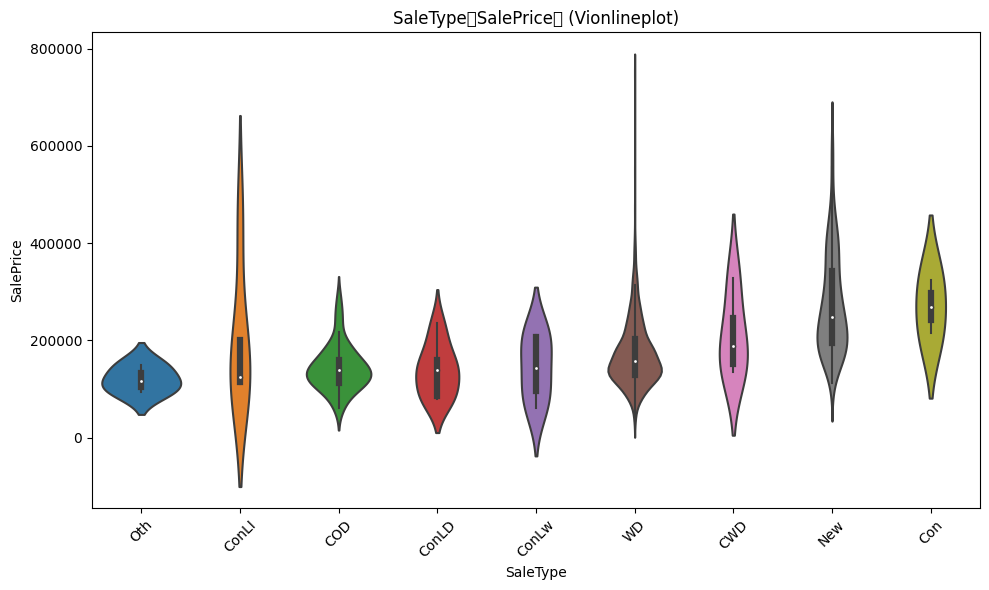

In [249]:
#10
# 上記に関連して、sale_type_stats　で　SaleTypeごとのSalePriceをバイオリンプロットで可視化　
#  return stats.sort_values(by="中央値", ascending=True)  # 平均で昇順ソート 　← (by="中央値"の" "部分を任意で変更すればよい

plt.figure(figsize=(10, 6))
sns.violinplot(data=train_df, x="SaleType", y="SalePrice", order=sale_type_stats.index)
plt.title("SaleType　SalePrice　 (Vionlineplot)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

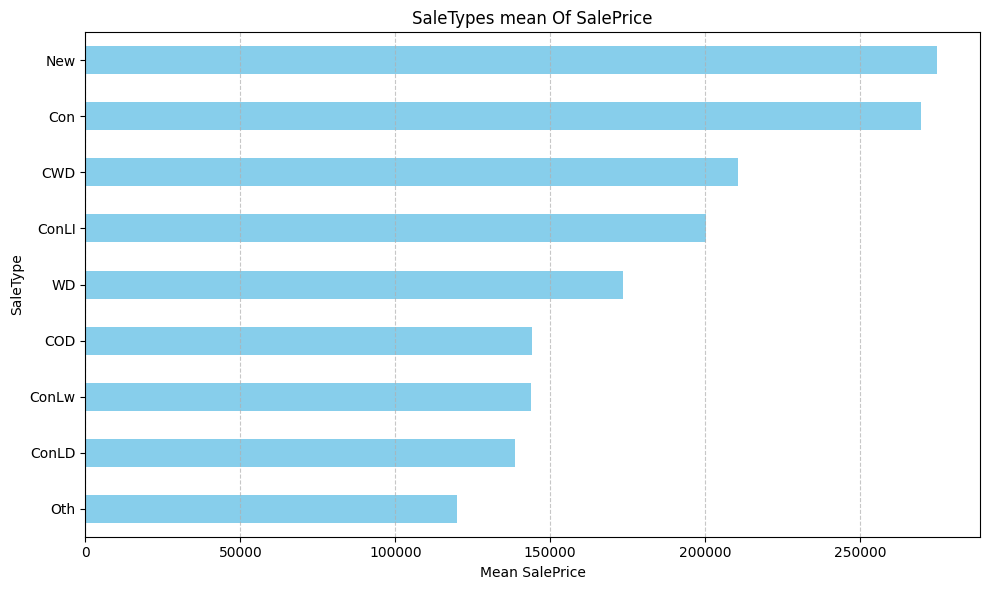

In [250]:
#11
# SaleType ごとの平均値を計算し、高い順に並べる
sale_type_mean = train_df.groupby("SaleType")["SalePrice"].mean().sort_values(ascending=False)

# 棒グラフ表示
plt.figure(figsize=(10, 6))
sale_type_mean.sort_values(ascending=True).plot(kind='barh', color='skyblue')  # 横棒グラフ
plt.xlabel('Mean SalePrice')
plt.title('SaleTypes mean Of SalePrice')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

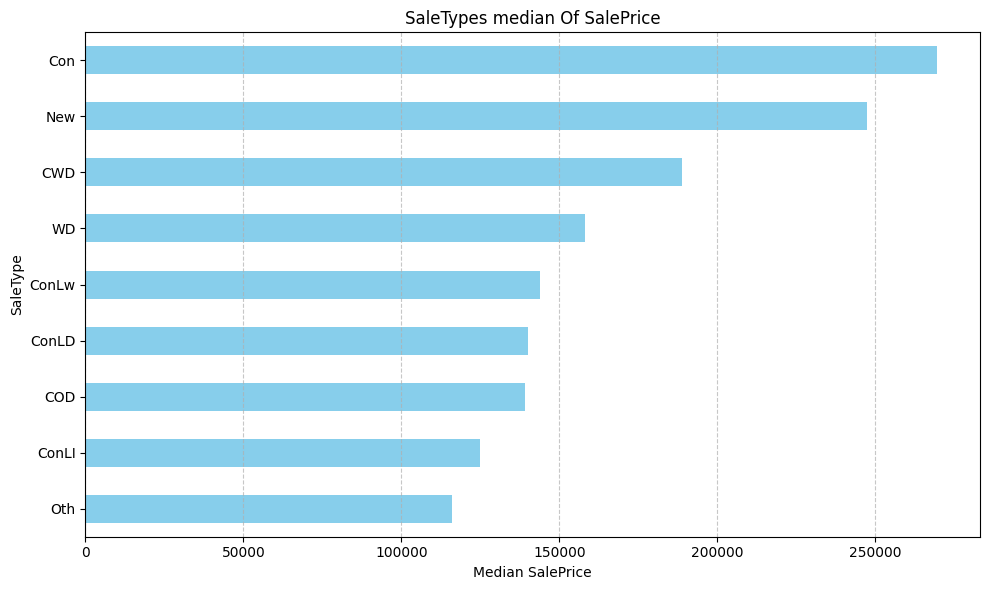

In [251]:
#12
# SaleType ごとの中央値を計算し、高い順に並べる
sale_type_median = train_df.groupby("SaleType")["SalePrice"].median().sort_values(ascending=False)

# 棒グラフ表示
plt.figure(figsize=(10, 6))
sale_type_median.sort_values(ascending=True).plot(kind='barh', color='skyblue')  # 横棒グラフ
plt.xlabel('Median SalePrice')
plt.title('SaleTypes median Of SalePrice')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [252]:
#13
#SaleType マッピング　テストデータに２の欠損値であり、型はobject であることに留意
#WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth 左記は学習用データ
#WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD  左記はテストデータ

#5 ## Con      269600.0  New      247453.0
#4 ## CWD      188750.0
#3 ## WD       158000.0
#2 ## ConLw    144000.0 ConLD    140000.0 COD      139000.0
#1 ### ConLI    125000.0
#0 ## Oth      116050.0        




SaleType_order = {
    'New': 5,
    'Con': 5,
    'CWD': 4,
    'WD': 3,
    'ConLw': 2,  
    'ConLD': 2,
    'COD': 2,
    'ConLI': 1,
    'Oth': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['SaleType'] = x_train['SaleType'].map(SaleType_order)
x_test['SaleType'] = x_test['SaleType'].map(SaleType_order)

#### マッピング後の確認

In [253]:
#10
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_train['SaleType'].isna().sum()
print(f"'SaleType' のマッピング後の欠損値件数: {missing_count} 件")


'SaleType' のマッピング後の欠損値件数: 0 件


In [254]:
#11
###マッピング後のtest用データの型と値の種類を確認する
missing_count = x_test['SaleType'].isna().sum()
print(f"'SaleType' のマッピング後の欠損値件数: {missing_count} 件")

'SaleType' のマッピング後の欠損値件数: 1 件


In [255]:
#12
#マッピング後の学習用データの平均、最大、最小を確認
x_train['SaleType'].describe()

count    1460.000000
mean        3.120548
std         0.632013
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: SaleType, dtype: float64

In [256]:
#13
#マッピング後の学習用データの平均、最大、最小を確認
x_test['SaleType'].describe()

count    1458.000000
mean        3.112483
std         0.633947
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: SaleType, dtype: float64

In [257]:
#14
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['SaleType'].quantile(0.25)
# q3 = x_train['SaleType'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['SaleType'] < lower) | (x_train['SaleType'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='SaleType', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("SaleType Outlier Visualization of SaleType")
# plt.ylabel('SaleType')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [258]:
#15
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['SaleType'].quantile(0.25)
# q3 = x_test['SaleType'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['SaleType'] < lower) | (x_test['SaleType'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='SaleType', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("SaleType Outlier Visualization of SaleType")
# plt.ylabel('SaleType')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## Neighborhood	のマッピング

In [259]:
#1
#学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_train_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_train_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Family]"
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, Oth]"
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW]"
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 6120, 7420, 11200, 11924, 12968]"
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75]"
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040, 2324, 912]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa..."
FullBath,4,"[2, 1, 3, 0]"
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]"
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
LotArea,1073,"[8450, 9600, 11250, 9550, 14260, 14115, 10084,..."
MSSubClass,15,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,..."
TotRmsAbvGrd,12,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]"
GrLivArea,861,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209..."


In [260]:
#2
#学習用データのカラム内のSaleType の種類数とサンプル値を確認する。

summary = pd.DataFrame({
    '種類数': [x_test_backup[col].nunique(dropna=True) for col in features],
    'サンプル値': [x_test_backup[col].dropna().unique()[:13] for col in features]  # 最大5種表示
    }, index=features)

#pandas のデフォルト表示幅制限を解除↓  
with pd.option_context('display.max_colwidth', None):
    display(summary)

summary

,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, AdjLand]"
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]"
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, NridgHt, Blmngtn, NoRidge, Somerst, SawyerW, Sawyer, NWAmes, OldTown]"
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680, 2280]"
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75]"
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 1092]"


,種類数,サンプル値
SaleCondition,6,"[Normal, Partial, Abnorml, Family, Alloca, Adj..."
FullBath,5,"[1, 2, 3, 4, 0]"
SaleType,9,"[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, ..."
Functional,7,"[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]"
MSZoning,5,"[RH, RL, RM, FV, C (all)]"
Neighborhood,25,"[NAmes, Gilbert, StoneBr, BrDale, NPkVill, Nri..."
LotArea,1106,"[11622, 14267, 13830, 9978, 5005, 10000, 7980,..."
MSSubClass,16,"[20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45..."
TotRmsAbvGrd,12,"[5, 6, 7, 4, 10, 8, 9, 3, 12, 11, 13, 15]"
GrLivArea,879,"[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465..."


In [261]:
#3
###学習用データの型と値の種類を確認する
print(x_train_backup['Neighborhood'].dtype)
print(x_train_backup['Neighborhood'].unique())

object
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In [262]:
#4
###test用データの型と値の種類を確認する
print(x_test_backup['Neighborhood'].dtype)
print(x_test_backup['Neighborhood'].unique())

object
['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']


In [263]:
#5
#学習用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_train_backup[features].isnull().sum(),
    '欠損率': x_train_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtExposure,38,0.026027
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342


In [264]:
#6
#test用データでの欠損件数の確認

missing_info = pd.DataFrame({
    '欠損件数': x_test_backup[features].isnull().sum(),
    '欠損率': x_test_backup[features].isnull().mean()
})

# 欠損があるカラムだけ表示（任意）
missing_info = missing_info[missing_info['欠損件数'] > 0]
missing_info = missing_info.sort_values(by='欠損率', ascending=False)

missing_info

,欠損件数,欠損率
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787
MSZoning,4,0.002742
Functional,2,0.001371
SaleType,1,0.000685
BsmtFinSF1,1,0.000685
KitchenQual,1,0.000685
GarageCars,1,0.000685


In [265]:
#7
###学習用データのNeighborhoodの欠損件数を個別に確認する。
missing_count = x_train_backup['Neighborhood'].isna().sum()
print(f"'Neighborhood' の欠損値件数: {missing_count} 件")

'Neighborhood' の欠損値件数: 0 件


In [266]:
#8
###test用データのNeighborhoodの欠損件数を個別に確認する。
missing_count = x_test_backup['Neighborhood'].isna().sum()
print(f"'Neighborhood' の欠損値件数: {missing_count} 件")

'Neighborhood' の欠損値件数: 0 件


In [267]:
#9
# 平均・中央値・件数・標準偏差・最小・最大・外れ値 を集計するコード
import pandas as pd
import numpy as np

# IQRを使った外れ値カウント関数
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((series < lower_bound) | (series > upper_bound)).sum()

# SaleType ごとの SalePrice の統計量を集計
def summarize_Neighborhood_type_stats(df):
    stats = df.groupby("Neighborhood")["SalePrice"].agg(
        平均="mean",
        中央値="median",
        標準偏差="std",
        件数="count",
        最小="min",
        最大="max"
    )
    # 外れ値数を計算して追加
    stats["外れ値数"] = df.groupby("Neighborhood")["SalePrice"].apply(count_outliers)
    return stats.sort_values(by="中央値", ascending=False)  # 中央値で昇順ソート

# 使用例（train_df を使って集計）
Neighborhood_type_stats = summarize_Neighborhood_type_stats(train_df)
print(Neighborhood_type_stats)

                         平均       中央値           標準偏差   件数      最小      最大  \
Neighborhood                                                                
NridgHt       316270.623377  315000.0   96392.544954   77  154000  611657   
NoRidge       335295.317073  301500.0  121412.658640   41  190000  755000   
StoneBr       310499.000000  278000.0  112969.676640   25  170000  556581   
Timber        242247.447368  228475.0   64845.651549   38  137500  378500   
Somerst       225379.837209  225500.0   56177.555888   86  144152  423000   
Veenker       238772.727273  218000.0   72369.317959   11  162500  385000   
Crawfor       210624.725490  200624.0   68866.395472   51   90350  392500   
ClearCr       212565.428571  200250.0   50231.538993   28  130000  328000   
CollgCr       197965.773333  197200.0   51403.666438  150  110000  424870   
Blmngtn       194870.882353  191000.0   30393.229219   17  159895  264561   
NWAmes        189050.068493  182900.0   37172.218106   73   82500  299800   

In [268]:
#10
# 上記に関連して、Neighborhood_type_stats　で　NeighborhoodごとのSalePriceをバイオリンプロットで可視化　
# return stats.sort_values(by="中央値", ascending=False)  # 中央値で昇順ソート

# plt.figure(figsize=(10, 6))
# sns.violinplot(data=train_df, x="Neighborhood", y="SalePrice", order=Neighborhood_type_stats.index)
# plt.title("Neighborhood　SalePrice　 (Vionlineplot)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [269]:
#11
#Neighborhood マッピング　
      
#7 NridgHt       316270.623377  315000.0   96392.544954   77  154000  611657   
#7 NoRidge       335295.317073  301500.0  121412.658640   41  190000  755000   
#7 StoneBr       310499.000000  278000.0  112969.676640   25  170000  556581   

#6 Timber        242247.447368  228475.0   64845.651549   38  137500  378500   
#6 Somerst       225379.837209  225500.0   56177.555888   86  144152  423000   
#6 Veenker       238772.727273  218000.0   72369.317959   11  162500  385000   
#6 Crawfor       210624.725490  200624.0   68866.395472   51   90350  392500   
#6 ClearCr       212565.428571  200250.0   50231.538993   28  130000  328000 

#5 CollgCr       197965.773333  197200.0   51403.666438  150  110000  424870   
#5 Blmngtn       194870.882353  191000.0   30393.229219   17  159895  264561   
#5 NWAmes        189050.068493  182900.0   37172.218106   73   82500  299800   
#5 Gilbert       192854.506329  181000.0   35986.779085   79  141000  377500   
#5 SawyerW       186555.796610  179900.0   55651.997820   59   76000  320000


#4 Mitchel       156270.122449  153500.0   36486.625334   49   84500  271000   
#4 NPkVill       142694.444444  146000.0    9377.314529    9  127500  155000   
#4 NAmes         145847.080000  140000.0   33075.345450  225   87500  345000  

#3 SWISU         142591.360000  139500.0   32622.917679   25   60000  200000   
#3 Blueste       137500.000000  137500.0   19091.883092    2  124000  151000   
#3 Sawyer        136793.135135  135000.0   22345.129157   74   62383  190000 

#2 BrkSide       124834.051724  124300.0   40348.689270   58   39300  223500   
#2 Edwards       128219.700000  121750.0   43208.616459  100   58500  320000   
#2 OldTown       128225.300885  119000.0   52650.583185  113   37900  475000 

#1 BrDale        104493.750000  106000.0   14330.176493   16   83000  125000   
#1 IDOTRR        100123.783784  103000.0   33376.710117   37   34900  169500   

#0 MeadowV        98576.470588   88000.0   23491.049610   17   75000  151400 


Neighborhood_order = {
    'NridgHt': 7,
    'NoRidge': 7,  
    'StoneBr': 7,
    'Timber': 6,
    'Somerst': 6,
    'Veenker': 6,
    'Crawfor': 6,
    'ClearCr': 6,
    'CollgCr': 5,
    'Blmngtn': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'SawyerW': 5,
    'Mitchel': 4,
    'NPkVill': 4,
    'NAmes': 4,
    'SWISU': 3,
    'Blueste': 3,
    'Sawyer': 3,
    'BrkSide': 2,
    'Edwards': 2,
    'OldTown': 2,
    'BrDale': 1,
    'IDOTRR': 1,
    'MeadowV': 0,
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['Neighborhood'] = x_train['Neighborhood'].map(Neighborhood_order)
x_test['Neighborhood'] = x_test['Neighborhood'].map(Neighborhood_order)

#### マッピング後の確認

In [270]:
#12
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_train['Neighborhood'].isna().sum()
print(f"'Neighborhood' のマッピング後の欠損値件数: {missing_count} 件")

'Neighborhood' のマッピング後の欠損値件数: 0 件


In [271]:
#13
###マッピング後の学習用データの型と値の種類を確認する
missing_count = x_test['Neighborhood'].isna().sum()
print(f"'Neighborhood' のマッピング後の欠損値件数: {missing_count} 件")

'Neighborhood' のマッピング後の欠損値件数: 0 件


In [272]:
#14
#マッピング後の学習用データの平均、最大、最小を確認
x_train['Neighborhood'].describe()

count    1460.000000
mean        4.250000
std         1.729427
min         0.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: Neighborhood, dtype: float64

In [273]:
#15
#マッピング後の学習用データの平均、最大、最小を確認
x_test['Neighborhood'].describe()

count    1459.000000
mean        4.176148
std         1.772316
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: Neighborhood, dtype: float64

In [274]:
#16
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_train['Neighborhood'].quantile(0.25)
# q3 = x_train['Neighborhood'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_train['Outlier_Flag'] = ((x_train['Neighborhood'] < lower) | (x_train['Neighborhood'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_train.index, y='Neighborhood', hue='Outlier_Flag', data=x_train, palette={False: 'blue', True: 'red'})
# plt.title("Neighborhood Outlier Visualization of Neighborhood")
# plt.ylabel('Neighborhood')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

In [275]:
#17
#マッピング後の学習データの外れ値の確認
# IQRを使った外れ値の範囲を計算


# q1 = x_test['Neighborhood'].quantile(0.25)
# q3 = x_test['Neighborhood'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5 * iqr
# upper = q3 + 1.5 * iqr

# # 外れ値のフラグを追加（True = 外れ値）
# x_test['Outlier_Flag'] = ((x_test['Neighborhood'] < lower) | (x_test['Neighborhood'] > upper))

# # 散布図で可視化（外れ値だけ赤く）
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=x_test.index, y='Neighborhood', hue='Outlier_Flag', data=x_test, palette={False: 'blue', True: 'red'})
# plt.title("Neighborhood Outlier Visualization of Neighborhood")
# plt.ylabel('Neighborhood')
# plt.xlabel('date index')
# plt.legend(title='Outlier?', labels=['Normal', 'Outlier'])
# plt.show()

## OverallQualの処理など（相関関係大、外れ値あり、float、歪度小、欠損値なし、マッピング処理なし）

### 1　目的変数との相関関係の確認

In [276]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます。
correlation = df_1['OverallQual'].corr(df_1['SalePrice'])

print("CSV→データフレームで直接計算した相関係数:")
print(correlation)

CSV→データフレームで直接計算した相関係数:
0.7909816005838047


### ２ 目的変数との相関関係の確認と説明

In [277]:
# データフレームから直接計算
correlation = df_1['OverallQual'].corr(df_1['SalePrice'])


# --- 結果の表示 ---
print("--- OverallQual と SalePrice の相関係数 ---")
print(f"{correlation:.4f}") # 小数点以下4桁で表示

print("\n【解説】")
if correlation > 0.7:
    print("-> 非常に強い正の相関があります。")
    print("   これは、OverallQual（総合的な品質）が高くなるほど、")
    print("   SalePrice（住宅価格）も顕著に高くなる傾向があることを示しています。")
elif correlation > 0.4:
    print("-> やや強い正の相関があります。")
else:
    print("-> 正の相関があります。")

--- OverallQual と SalePrice の相関係数 ---
0.7910

【解説】
-> 非常に強い正の相関があります。
   これは、OverallQual（総合的な品質）が高くなるほど、
   SalePrice（住宅価格）も顕著に高くなる傾向があることを示しています。


### 3 目的変数に対しての外れ値の確認

In [278]:
# --- グラフ描画のためのデータ準備 ---
# x_train と y_train をグラフ描画のために一時的に結合します。
# これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- グラフの描画 (箱ひげ図) ---
# print("\n--- グラフを生成します ---")
# plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

# sns.boxplot(x='OverallQual', y='SalePrice', data=plotting_data)

# # グラフのタイトルとラベルを設定
# plt.title('OverallQual_with_SalePrice_plost（Outs）', fontsize=16)
# plt.xlabel('OverallQual (Toatal Quall)', fontsize=12)
# plt.ylabel('SalePrice', fontsize=12)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


# # --- 補足：散布図による確認 ---
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='OverallQual', y='SalePrice', data=plotting_data, alpha=0.6)
# plt.title('OverallQual with SalePrice plots', fontsize=16)
# plt.xlabel('OverallQual (Toatal Quall)', fontsize=12)
# plt.ylabel('SalePrice (SalePrice)', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

### 4　目的変数に対しての外れ値の数値詳細

In [279]:
# --- 1. グラフと計算のためのデータ準備 ---
# x_train と y_train を一時的に結合します。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- 2. 外れ値の計算 ---
# OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('OverallQual')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('OverallQual')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- OverallQualごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['OverallQual']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # OverallQualごとに何件の外れ値があったかを表示
# print("\n--- 品質レベルごとの外れ値の件数 ---")
# print(outliers_df['OverallQual'].value_counts().sort_index())

In [280]:
# 0-1正規分布に近いかどうか確認する。
# ただし、このような特徴量は、１～１０と明確な順序があるため、対数変換は有用な「順序情報」を歪めてしまうため、むしろ精度を悪化させる。

In [281]:
#0-2実践的な判断フロー
#計算: 特徴量の歪度を計算する (.skew())。
#閾値チェック: 絶対値が 0.5 や 1.0 を超えているか確認する。
#性質チェック: それは変換可能な「連続値」か？ (OverallQual のようなものではないか？)
#可視化: ヒストグラムで分布の形を目で見て確認する。
#実験: 変換した場合としない場合で、モデルの精度を比較してみる。
#この多角的な視点を持つことが、より精度の高いモデルを作成するための鍵となります。

### 5 データ（選択した特徴量）の形の確認

In [282]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['OverallQual'], kde=True)
# plt.title('Before OverallQual(train) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('Counts')

In [283]:
#テスト用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['OverallQual'], kde=True)
# plt.title('Before OverallQual(test) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('Counts')

### 6 データ（選択した特徴量）の歪度の確認

In [284]:
#testデータのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['OverallQual'], kde=True)
# plt.title('Before OverallQual(test) plots')
# plt.xlabel('OverallQual')
# plt.ylabel('度数')

### ７ データ（選択した特徴量）の歪度への説明

In [285]:
# 学習用データの歪度を調べる
# --- 1. 'OverallQual' の歪度を計算 ---
skewness = x_train['OverallQual'].skew()


# --- 2. 結果の表示 ---
print(f" OverallQualの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 OverallQualの歪度(学習用): 0.2169
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。


In [286]:
#test用データの歪度を調べる
# --- 1. 'OverallQual' の歪度を計算 ---
skewness = x_test['OverallQual'].skew()


# --- 2. 結果の表示 ---
print(f" OverallQualの歪度（テスト用）: {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布です。対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 OverallQualの歪度（テスト用）: 0.1812
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布です。対数変換は不要の可能性が大です。


### 8 データ（選択した特徴量）の型と種類の確認

In [287]:
###学習用データの型と値の種類を確認する
print(x_train['OverallQual'].dtype)
print(x_train['OverallQual'].unique())

int64
[ 7  6  8  5  9  4 10  3  1  2]


In [288]:
###test用データの型と値の種類を確認する
print(x_test['OverallQual'].dtype)
print(x_test['OverallQual'].unique())

int64
[ 5  6  8  7  4  9  2  3 10  1]


### 9 データ（選択した特徴量）の統計情報とそのグラフの確認

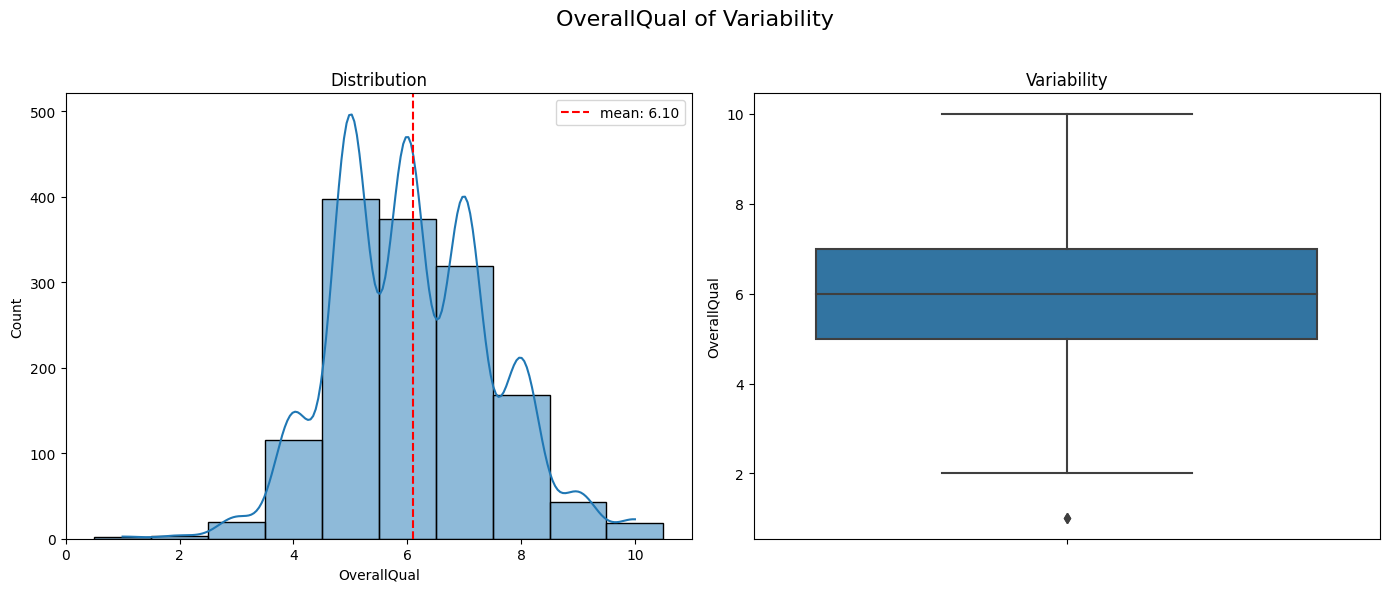


--- 基本的な統計情報 (describe) ---
count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


In [289]:
qual_series = x_train['OverallQual']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('OverallQual of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('OverallQual')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('OverallQual')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

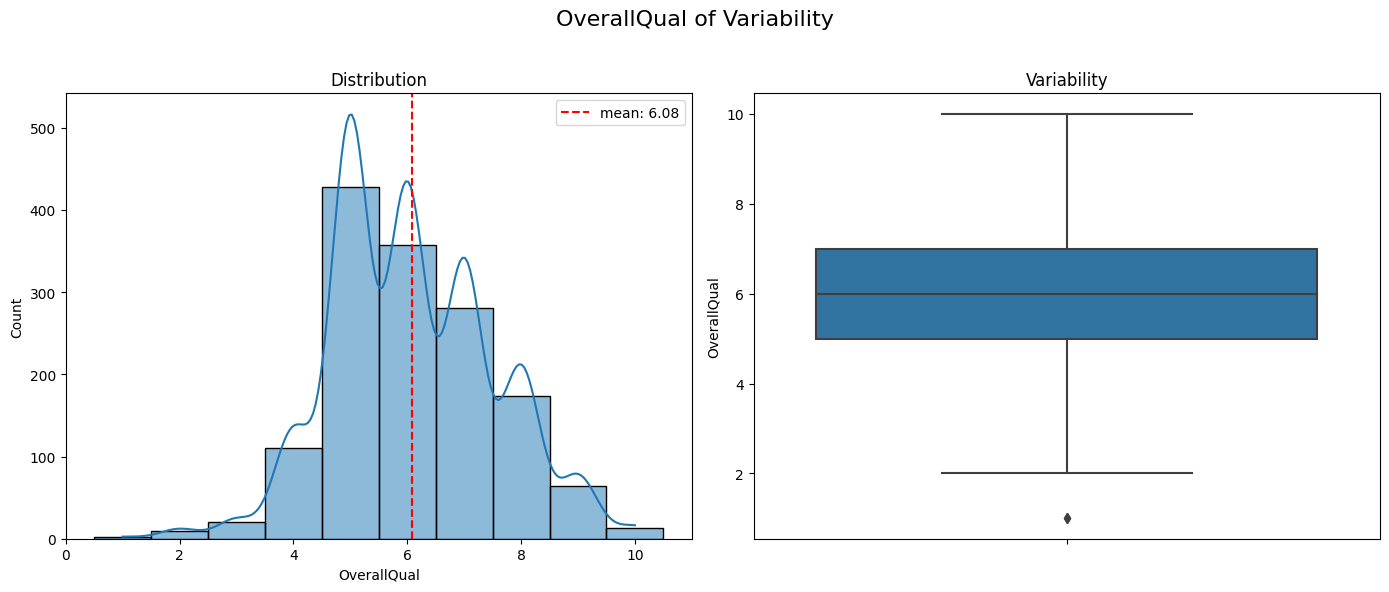


--- 基本的な統計情報 (describe) ---
count    1459.000000
mean        6.078821
std         1.436812
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


In [290]:
qual_series = x_test['OverallQual']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('OverallQual of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('OverallQual')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('OverallQual')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

### 10 データ（選択した特徴量）の欠損値の確認

In [291]:
###学習用データのOverallQualの欠損件数を個別に確認する。
missing_count = x_train['OverallQual'].isna().sum()
print(f"'OverallQual(学習用）' の欠損値件数: {missing_count} 件")

'OverallQual(学習用）' の欠損値件数: 0 件


In [292]:
###test用データのOverallQualの欠損件数を個別に確認する。
missing_count = x_test['OverallQual'].isna().sum()
print(f"'OverallQual（テスト用）' の欠損値件数: {missing_count} 件")

'OverallQual（テスト用）' の欠損値件数: 0 件


## FullBath	特徴量の追加と確認

In [293]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます。
correlation = df_1['FullBath'].corr(df_1['SalePrice'])

print("CSV→データフレームで直接計算した相関係数:")
print(correlation)

print("\n【解説】")
if correlation > 0.7:
    print("-> 非常に強い正の相関があります。")
    print("   これは、FullBath（バスルームの数）が多くなるほど、")
    print("   SalePrice（住宅価格）も顕著に高くなる傾向があることを示しています。")
elif correlation > 0.4:
    print("-> やや強い正の相関があります。")
else:
    print("-> 正の相関があります。")

CSV→データフレームで直接計算した相関係数:
0.5606637627484456

【解説】
-> やや強い正の相関があります。



--- グラフを生成します ---


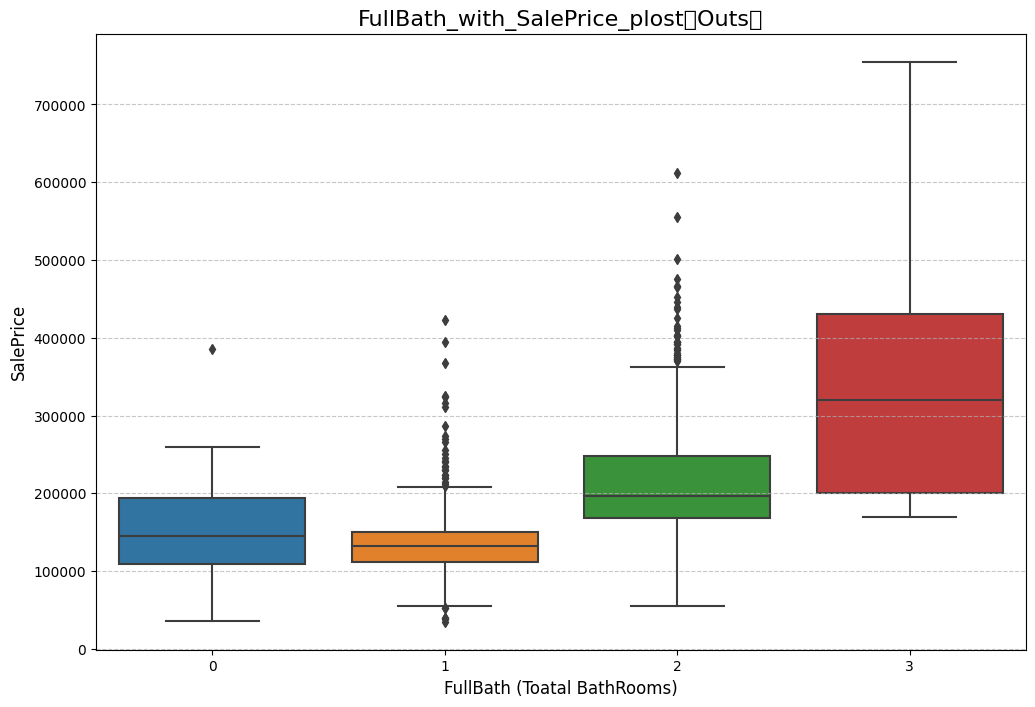

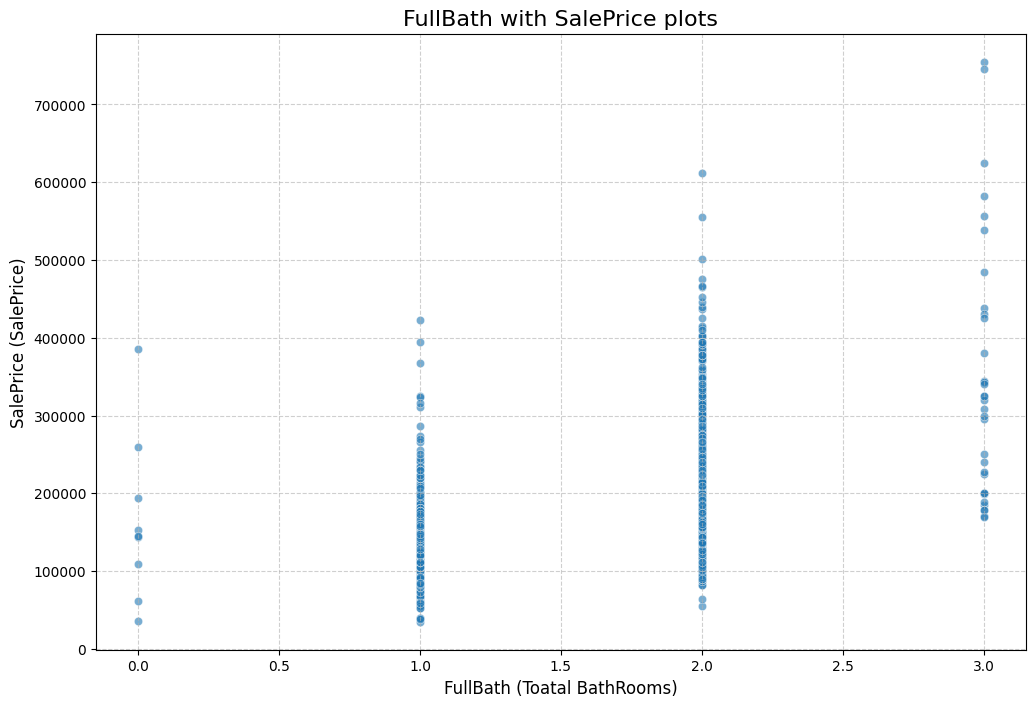

In [294]:
# --- グラフ描画のためのデータ準備 ---
# x_train と y_train をグラフ描画のために一時的に結合します。
# これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- グラフの描画 (箱ひげ図) ---
print("\n--- グラフを生成します ---")
plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

sns.boxplot(x='FullBath', y='SalePrice', data=plotting_data)

# グラフのタイトルとラベルを設定
plt.title('FullBath_with_SalePrice_plost（Outs）', fontsize=16)
plt.xlabel('FullBath (Toatal BathRooms)', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- 補足：散布図による確認 ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FullBath', y='SalePrice', data=plotting_data, alpha=0.6)
plt.title('FullBath with SalePrice plots', fontsize=16)
plt.xlabel('FullBath (Toatal BathRooms)', fontsize=12)
plt.ylabel('SalePrice (SalePrice)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [295]:
# --- 1. グラフと計算のためのデータ準備 ---
# x_train と y_train を一時的に結合します。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- 2. 外れ値の計算 ---
# OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
Q1 = plotting_data.groupby('FullBath')['SalePrice'].quantile(0.25)
Q3 = plotting_data.groupby('FullBath')['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の境界線（下限と上限）を計算
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 計算結果を一つのデータフレームにまとめる
outlier_stats = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})
print("\n--- FullBathごとの外れ値の境界線 ---")
print(outlier_stats)


# --- 3. 外れ値の特定と件数の表示 ---
# 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# 各行ごとに判定するため、ここではループやapplyを使います。

outliers_list = []
for index, row in plotting_data.iterrows():
    qual = row['FullBath']
    price = row['SalePrice']
    
    # その行の品質レベルに対応する境界線を取得
    bounds = outlier_stats.loc[qual]
    
    # 境界線の外にあるかどうかをチェック
    if price < bounds['lower_bound'] or price > bounds['upper_bound']:
        outliers_list.append(row)

# 外れ値のリストを新しいデータフレームに変換
outliers_df = pd.DataFrame(outliers_list)


print(f"\n--- 外れ値の件数 ---")
print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# OverallQualごとに何件の外れ値があったかを表示
print("\n--- 品質レベルごとの外れ値の件数 ---")
print(outliers_df['FullBath'].value_counts().sort_index())


--- FullBathごとの外れ値の境界線 ---
                Q1        Q3       IQR  lower_bound  upper_bound
FullBath                                                        
0         108959.0  194201.0   85242.0    -18904.00    322064.00
1         112000.0  150562.5   38562.5     54156.25    208406.25
2         168500.0  248082.0   79582.0     49127.00    367455.00
3         200624.0  430000.0  229376.0   -143440.00    774064.00

--- 外れ値の件数 ---
合計 69 件の外れ値が検出されました。

--- 品質レベルごとの外れ値の件数 ---
FullBath
0.0     1
1.0    33
2.0    35
Name: count, dtype: int64


In [296]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['FullBath'], kde=True)
# plt.title('Before FullBath(train) plots')
# plt.xlabel('FullBath')
# plt.ylabel('Counts')

In [297]:
#test用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['FullBath'], kde=True)
# plt.title('Before FullBath(train) plots')
# plt.xlabel('FullBath')
# plt.ylabel('Counts')

In [298]:
# 学習用データの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_train['FullBath'].skew()


# --- 2. 結果の表示 ---
print(f" FullBathの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 FullBathの歪度(学習用): 0.0366
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。


In [299]:
# test用データの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_test['FullBath'].skew()


# --- 2. 結果の表示 ---
print(f" FullBathの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 FullBathの歪度(学習用): 0.2958
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。


In [300]:
###学習用データの型と値の種類を確認する
print(x_train['FullBath'].dtype)
print(x_train['FullBath'].unique())

int64
[2 1 3 0]


In [301]:
###test用データの型と値の種類を確認する
###testデータに４という学習データにない値があるので、これを学習させる必要がある。
print(x_test['FullBath'].dtype)
print(x_test['FullBath'].unique())

int64
[1 2 3 4 0]


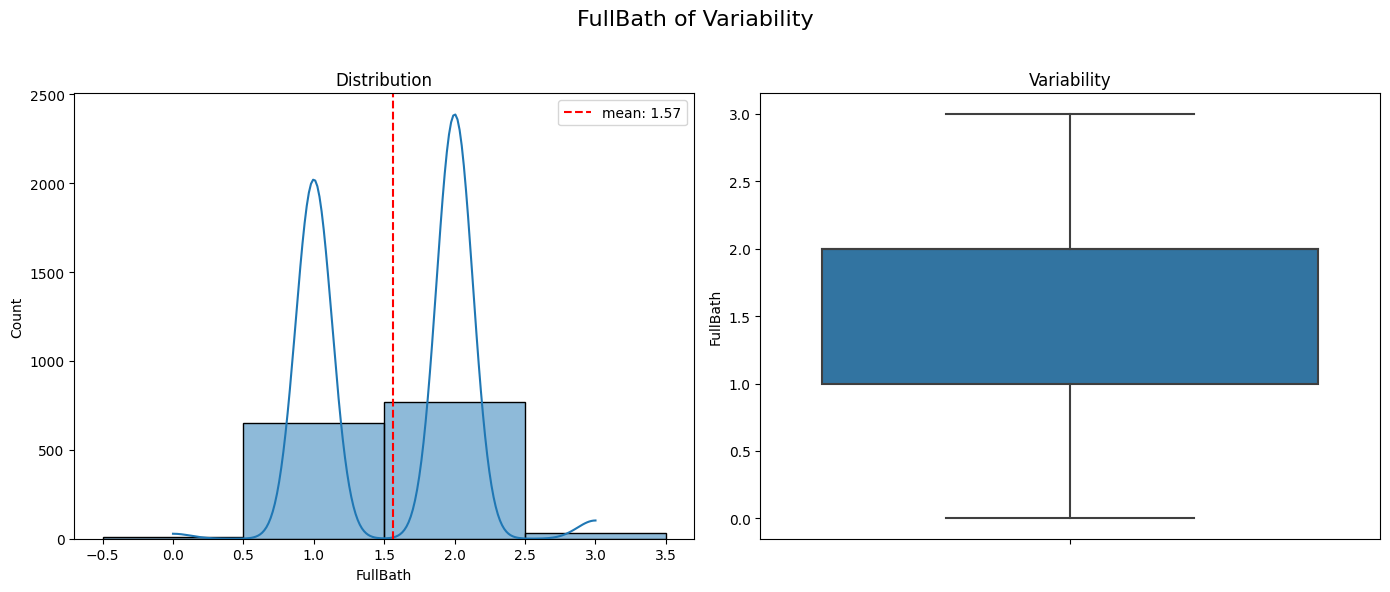


--- 基本的な統計情報 (describe) ---
count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64


In [302]:
qual_series = x_train['FullBath']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('FullBath of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('FullBath')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('FullBath')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

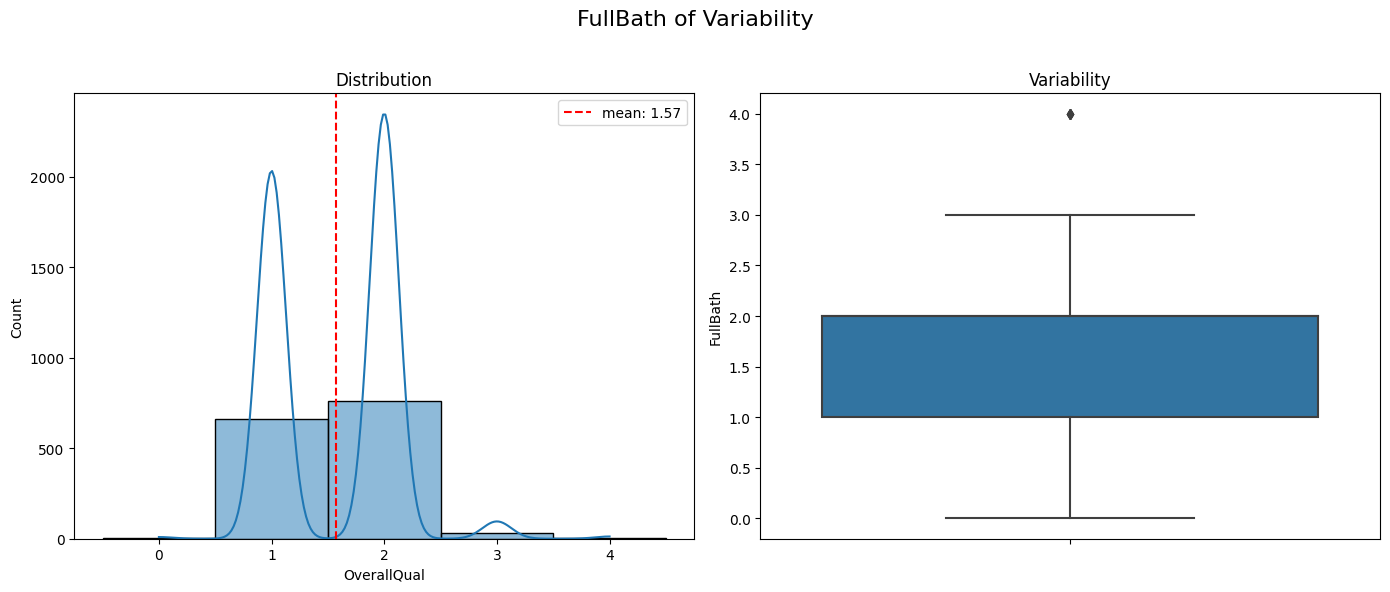


--- 基本的な統計情報 (describe) ---
count    1459.000000
mean        1.570939
std         0.555190
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: FullBath, dtype: float64


In [303]:
qual_series = x_test['FullBath']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('FullBath of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('OverallQual')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('FullBath')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

In [304]:
###学習用データのFullBathの欠損件数を個別に確認する。
missing_count = x_train['FullBath'].isna().sum()
print(f"'FullBath(学習用）' の欠損値件数: {missing_count} 件")

'FullBath(学習用）' の欠損値件数: 0 件


In [305]:
###test用データのFullBathの欠損件数を個別に確認する。
missing_count = x_test['FullBath'].isna().sum()
print(f"'FullBath(test用）' の欠損値件数: {missing_count} 件")

'FullBath(test用）' の欠損値件数: 0 件


In [306]:
#FullBath の特徴量は、学習用データでは１，２，３、０　の４種類　テストデータでは１，２，３，４，０ の５種類を考慮したマッピング
FullBath_order = {
     4: '4',
     3: '3',
     2: '2',  
     1: '1',
     0: '0',
}


# 数値へマッピング（安全で一貫性のある変換）
x_train['FullBath'] = x_train['FullBath'].map(FullBath_order)
x_test['FullBath'] = x_test['FullBath'].map(FullBath_order)

In [307]:
#Objectで出力される型をintにキャストしておく
x_train['FullBath'] = x_train['FullBath'].astype(int)
x_test['FullBath'] = x_test['FullBath'].astype(int)

In [308]:
###マッピング後の学習用データの型と値の種類を確認する
print(x_train['FullBath'].dtype)
print(x_train['FullBath'].unique())

int64
[2 1 3 0]


In [309]:
###マッピング後のtest用データの型と値の種類を確認する
print(x_test['FullBath'].dtype)
print(x_test['FullBath'].unique())

int64
[1 2 3 4 0]


In [310]:
# --- 2. 'FullBath' が 4 の物件を絞り込む ---
# df_train['FullBath'] == 4 という条件に合う行だけを抽出します。
four_bath_houses = x_test[x_test['FullBath'] == 4].copy()


# --- 3. 該当する物件の情報を表示 ---
if not four_bath_houses.empty:
    print(f"--- testデータ内で 'FullBath' が 4 の物件は {len(four_bath_houses)} 件見つかりました ---")
    
    
else:
    print("学習データ内には 'FullBath' が 4 の物件は見つかりませんでした。")

--- testデータ内で 'FullBath' が 4 の物件は 4 件見つかりました ---


In [311]:
# --- 2. 'FullBath' が 4 の物件を絞り込む ---
# df_train['FullBath'] == 4 という条件に合う行だけを抽出します。
four_bath_houses = x_train[x_train['FullBath'] == 4].copy()


# --- 3. 該当する物件の情報を表示 ---
if not four_bath_houses.empty:
    print(f"--- 学習データ内で 'FullBath' が 4 の物件は {len(four_bath_houses)} 件見つかりました ---")
    
    
else:
    print("学習データ内には 'FullBath' が 4 の物件は見つかりませんでした。")

学習データ内には 'FullBath' が 4 の物件は見つかりませんでした。


# 特徴量新規追加の例　YearBuilt と　YrSold（x_train['YrSold'] - x_train['YearBuilt']）＝x_train Age の特徴量の追加

In [312]:
###学習用データ（futures に入れる前）の型と値の種類を確認する
print(train_df['YearBuilt'].dtype)
print(train_df['YearBuilt'].unique())

int64
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]


In [313]:
####学習用データのYearBuiltの欠損件数を個別に確認する。
missing_count = train_df['YearBuilt'].isna().sum()
print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

'YearBuilt(学習用）' の欠損値件数: 0 件


In [314]:
###test用データ（futures に入れる前）の型と値の種類を確認する
print(test['YearBuilt'].dtype)
print(test['YearBuilt'].unique())

int64
[1961 1958 1997 1998 1992 1993 1990 1970 1999 1971 1975 2009 2005 2003
 2002 2006 2004 1920 1974 2000 2010 1967 1978 1966 1964 1962 1952 1949
 1959 1956 1955 1948 1960 1963 1900 1957 1938 1923 1890 1910 1922 1950
 1925 1939 1940 1942 1936 1930 1915 1912 1917 1907 1968 1977 1927 1947
 1954 1987 1996 1972 1945 1924 1931 1941 1994 1989 1921 1896 1976 2008
 1965 1973 1984 1985 1991 1969 1995 1980 2007 1986 1981 1951 1953 1935
 1902 1946 1934 1983 1880 1979 2001 1916 1918 1988 1937 1905 1928 1926
 1929 1914 1895 1982 1879 1901 1919 1932]


In [315]:
####test用データのYearBuiltの欠損件数を個別に確認する。
missing_count = test['YearBuilt'].isna().sum()
print(f"'YearBuilt(test用）' の欠損値件数: {missing_count} 件")

'YearBuilt(test用）' の欠損値件数: 0 件


In [316]:
##学習用データ（futures に入れる前）の型と値の種類を確認する
print(train_df['YrSold'].dtype)
print(train_df['YrSold'].unique())

int64
[2008 2007 2006 2009 2010]


In [317]:
####学習用データのYrSoldの欠損件数を個別に確認する。
missing_count = train_df['YrSold'].isna().sum()
print(f"'YrSold(学習用）' の欠損値件数: {missing_count} 件")

'YrSold(学習用）' の欠損値件数: 0 件


In [318]:
##test用データ（futures に入れる前）の型と値の種類を確認する
print(test['YrSold'].dtype)
print(test['YrSold'].unique())

int64
[2010 2009 2008 2007 2006]


In [319]:
####test用データのYrSoldの欠損件数を個別に確認する。
missing_count = test['YrSold'].isna().sum()
print(f"'YrSold(test用）' の欠損値件数: {missing_count} 件")

'YrSold(test用）' の欠損値件数: 0 件


In [320]:
#YearBuilt と　YrSold は共にint64であり、欠損値なし。

In [321]:
# --- ここが追加するコード ---
# 'Age'という新しい列に、'YrSold'列と'YearBuilt'列の差を代入する.負の相関関係となる。
#また、x_train はfutures で選択後のデータであり、この場合選択されていないためエラーとなる。よって上記引き算は,特徴量選択前のtrain_df で行えばよい。
x_train['Age'] = train_df['YrSold'] - train_df['YearBuilt']
x_test['Age'] = test['YrSold'] - test['YearBuilt']

In [322]:
#新しい特徴量がx_train(特徴量をfuturesでいれたデータ)に反映されていることを末尾で確認
x_train.head()

,SaleCondition,FullBath,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age
0,0,2,3,6,2,5,-0.254076,3,8,0.380070,-0.453608,7,2.0,2.0,0.0,5.0,0.452790,4,1,2,3,2,2.0,0.281573,5,5
1,0,2,3,6,2,6,0.030015,3,6,-0.312090,0.343643,6,2.0,2.0,3.0,4.0,0.834679,4,1,2,2,1,2.0,-0.082816,8,31
2,0,2,3,6,2,5,0.437624,3,6,0.497489,-0.327933,7,2.0,2.0,1.0,5.0,0.143910,4,1,2,3,2,2.0,0.530021,5,7
3,1,1,3,6,2,6,0.017663,2,7,0.390885,-0.247423,7,1.0,3.0,0.0,4.0,-0.235170,3,1,2,3,1,3.0,0.670807,5,91
4,0,2,3,6,2,7,1.181201,3,9,1.134029,0.113893,8,2.0,2.0,2.0,5.0,0.381186,4,1,2,3,2,3.0,1.474120,5,8


In [323]:
#新しい特徴量がx_test(特徴量をfuturesでいれたデータ)に反映されていることを末尾で確認
x_test.head()

,SaleCondition,FullBath,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age
0,0,1,3.0,6.0,1.0,4,0.529521,3,5,-0.877559,-0.375061,5,1.0,2.0,0.0,2.0,0.118638,2,1,2,2.0,1,1.0,1.035197,6,49
1,0,1,3.0,6.0,2.0,4,1.182930,3,6,-0.208575,0.475209,6,1.0,2.0,0.0,4.0,0.757459,2,1,2,3.0,1,1.0,-0.695652,6,52
2,0,2,3.0,6.0,2.0,5,1.074975,3,6,0.254925,-0.312224,5,2.0,2.0,0.0,5.0,0.572131,3,1,2,2.0,1,2.0,0.008282,5,13
3,0,2,3.0,6.0,2.0,5,0.123394,3,7,0.216300,-0.316151,6,1.0,2.0,0.0,5.0,0.306774,4,1,2,3.0,1,2.0,-0.041408,6,12
4,0,2,3.0,6.0,2.0,7,-1.105114,1,5,-0.284280,0.378989,8,2.0,2.0,0.0,4.0,-0.169182,4,1,2,3.0,2,2.0,0.107660,5,18


In [324]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます
correlation = x_train['Age'].corr(df_1['SalePrice'])

print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
print(correlation)

CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:
-0.523350417546816


In [325]:
#学習用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_train['Age'], kde=True)
# plt.title('Before Age(train) plots')
# plt.xlabel('Age')
# plt.ylabel('Counts')

In [326]:
#test用データのヒストグラムの表示
# plt.figure(figsize=(12, 5))

# # 左側のプロット：変換前のヒストグラム
# plt.subplot(1, 2, 1)
# sns.histplot(x_test['Age'], kde=True)
# plt.title('Before Age(test) plots')
# plt.xlabel('Age')
# plt.ylabel('Counts')

In [327]:
##新規作成後の学習用データ型と値の種類を確認する
print(x_train['Age'].dtype)
print(x_train['Age'].unique())

int64
[  5  31   7  91   8  16   3  36  77  69  43   1  46  48  78  40  39   4
  51   6  42   2  59  49  81  88  15  55  57  53  41  24  33  47  89  10
  72  25  52  44   0  87  12  65  34  11  56  95  60  99  14  94  13  45
  97  90  30  76 122  54  62  20  37  68  50  71   9  38  18  58  70  32
  35  83  84  66  19  22  86  98 114  93  75  82  17 106  29  96  27  92
 128  61  67  21  26 108  28  63  73  74  80 115 126 102  85  23 110 117
 129  64 100 111 104 119 127 107 135 109 136 103  79 125]


In [328]:
##新規作成後のテスト用データ型と値の種類を確認する
print(x_test['Age'].dtype)
print(x_test['Age'].unique())

int64
[ 49  52  13  12  18  17  20  40  11  39  35   1   5   7   8   4   6  90
  36  10   0  43  32  44  46  48  58  61  51  54  55  62  50  47 110  53
  72  87 120 100  88  60  85  71  70  68  74  80  95  98  93 103  42  33
  83  63  56  23  14  38  65  86  79  69  16  21  89 114  34   2  45  37
  26  25  19  41  15  31  29   9   3  28  64  57  59 109  84  94  99 119
  92  82 107  22  75 129  30  91 118 108  73  67  78  96  24 113  27 117
 112  81  97  77 128 106  -1  66  76 101]



--- グラフを生成します ---


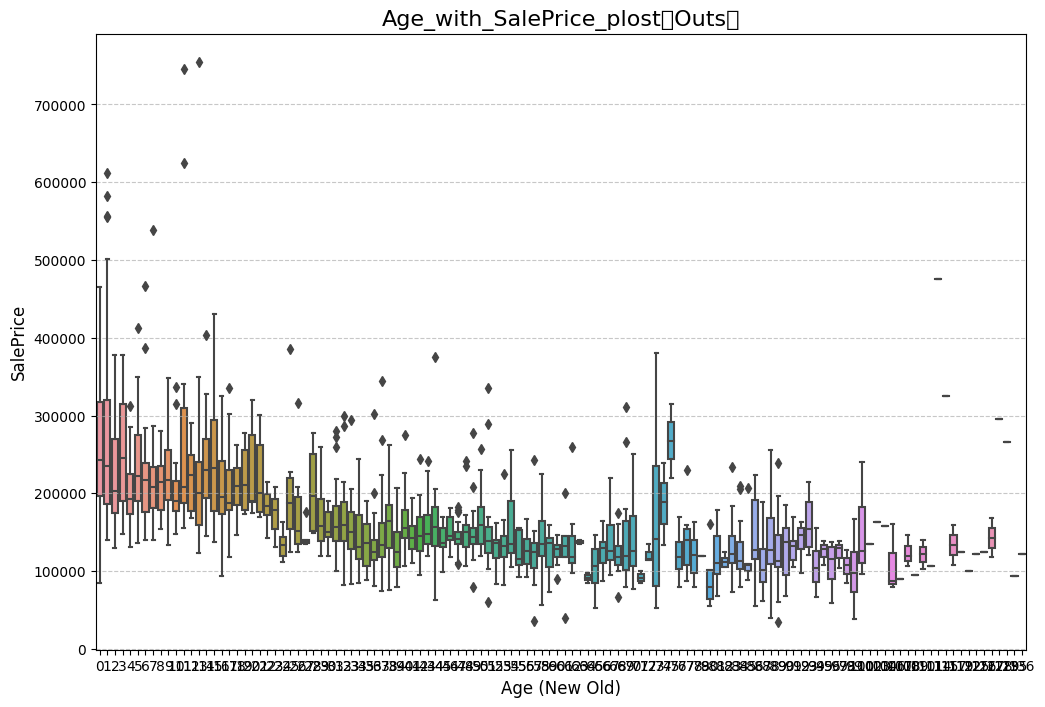

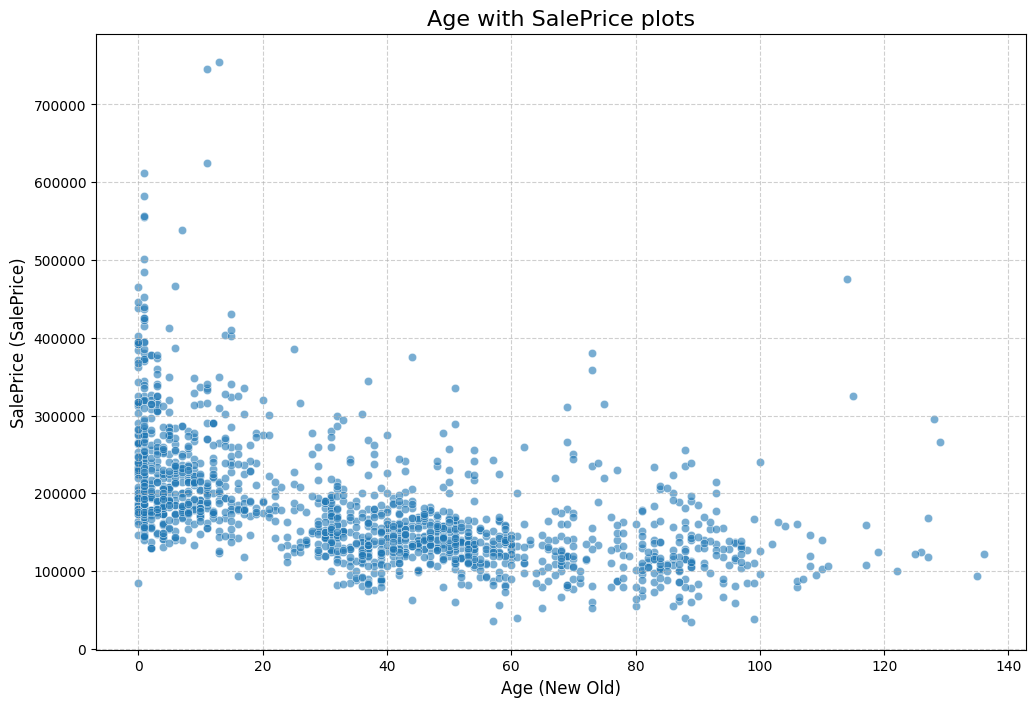

In [329]:
# --- グラフ描画のためのデータ準備 ---
# x_train と y_train をグラフ描画のために一時的に結合します。
# これにより、'OverallQual' と 'SalePrice' を同時に扱えるようになります。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- グラフの描画 (箱ひげ図) ---
print("\n--- グラフを生成します ---")
plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

sns.boxplot(x='Age', y='SalePrice', data=plotting_data)

# グラフのタイトルとラベルを設定
plt.title('Age_with_SalePrice_plost（Outs）', fontsize=16)
plt.xlabel('Age (New Old)', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- 補足：散布図による確認 ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age', y='SalePrice', data=plotting_data, alpha=0.6)
plt.title('Age with SalePrice plots', fontsize=16)
plt.xlabel('Age (New Old)', fontsize=12)
plt.ylabel('SalePrice (SalePrice)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [330]:
# --- 1. グラフと計算のためのデータ準備 ---
# x_train と y_train を一時的に結合します。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- 2. 外れ値の計算 ---
# OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
Q1 = plotting_data.groupby('Age')['SalePrice'].quantile(0.25)
Q3 = plotting_data.groupby('Age')['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の境界線（下限と上限）を計算
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 計算結果を一つのデータフレームにまとめる
outlier_stats = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})
print("\n--- Ageごとの外れ値の境界線 ---")
print(outlier_stats)


# --- 3. 外れ値の特定と件数の表示 ---
# 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# 各行ごとに判定するため、ここではループやapplyを使います。

outliers_list = []
for index, row in plotting_data.iterrows():
    qual = row['Age']
    price = row['SalePrice']
    
    # その行の品質レベルに対応する境界線を取得
    bounds = outlier_stats.loc[qual]
    
    # 境界線の外にあるかどうかをチェック
    if price < bounds['lower_bound'] or price > bounds['upper_bound']:
        outliers_list.append(row)

# 外れ値のリストを新しいデータフレームに変換
outliers_df = pd.DataFrame(outliers_list)


print(f"\n--- 外れ値の件数 ---")
print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# OverallQualごとに何件の外れ値があったかを表示
print("\n--- 品質レベルごとの外れ値の件数 ---")
print(outliers_df['Age'].value_counts().sort_index())


--- Ageごとの外れ値の境界線 ---
            Q1         Q3        IQR  lower_bound  upper_bound
Age                                                           
0    196600.00  318000.00  121400.00    14500.000   500100.000
1    186375.00  320000.00  133625.00   -14062.500   520437.500
2    174950.00  270000.00   95050.00    32375.000   412575.000
3    189750.00  315500.00  125750.00     1125.000   504125.000
4    173500.00  225000.00   51500.00    96250.000   302250.000
5    190000.00  274975.00   84975.00    62537.500   402437.500
6    175975.00  239014.50   63039.50    81415.750   333573.750
7    180500.00  233250.00   52750.00   101375.000   312375.000
8    178000.00  235000.00   57000.00    92500.000   320500.000
9    192000.00  255500.00   63500.00    96750.000   350750.000
10   177125.00  215500.00   38375.00   119562.500   273062.500
11   187875.00  309312.50  121437.50     5718.750   491468.750
12   177125.00  249625.00   72500.00    68375.000   358375.000
13   158800.00  240000.00   8120

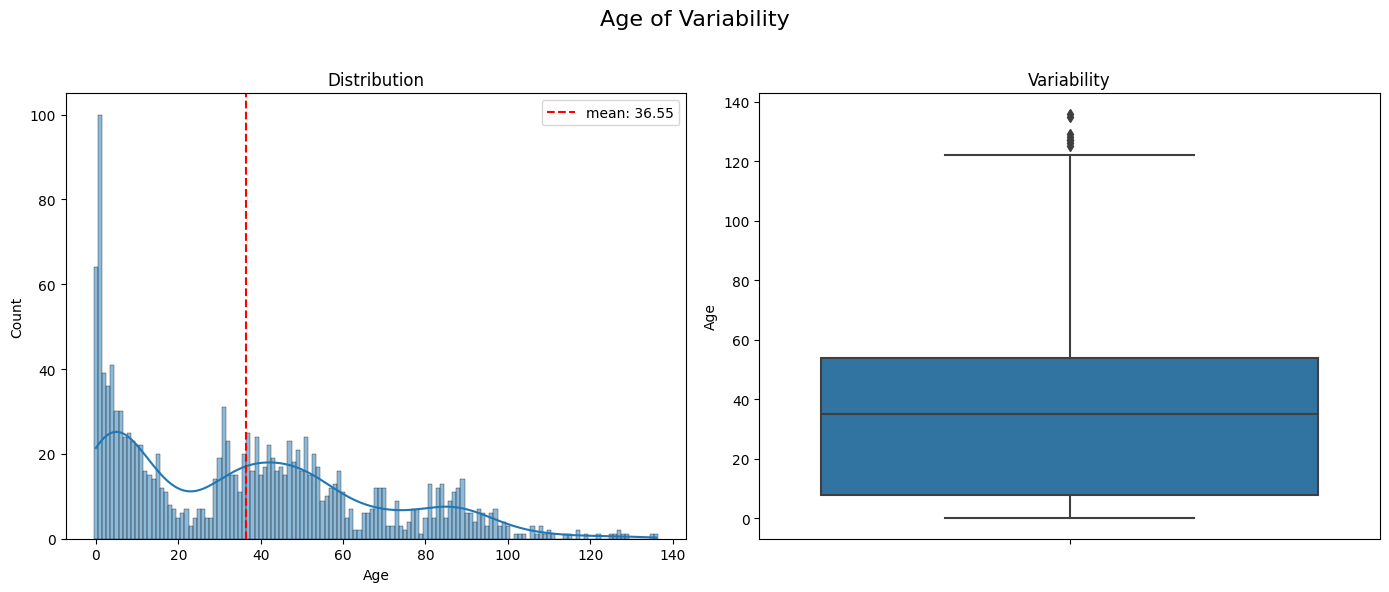


--- 基本的な統計情報 (describe) ---
count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age, dtype: float64


In [331]:
qual_series = x_train['Age']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Age of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('Age')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

# 特徴量リフォームからの年数追加

In [332]:
print(train_df['YearRemodAdd'].dtype)
print(train_df['YearRemodAdd'].unique())

int64
[2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]


In [333]:
print(test['YearRemodAdd'].dtype)
print(test['YearRemodAdd'].unique())

int64
[1961 1958 1998 1992 1994 2007 1990 1970 1999 1971 1975 2010 2005 2006
 2004 2002 1950 1993 2000 2003 1967 1978 1966 1964 2001 2008 2009 1959
 1956 1952 1955 1960 1984 1954 1957 1962 1997 1980 1968 1987 1979 1996
 1972 1985 1991 1989 1977 1976 1973 1986 1969 1995 1974 1981 1965 1951
 1953 1963 1982 1988 1983]


In [334]:
missing_count = train_df['YearRemodAdd'].isna().sum()
print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

'YearBuilt(学習用）' の欠損値件数: 0 件


In [335]:
missing_count = test['YearRemodAdd'].isna().sum()
print(f"'YearBuilt(学習用）' の欠損値件数: {missing_count} 件")

'YearBuilt(学習用）' の欠損値件数: 0 件


In [336]:
#また、x_train はfutures で選択後のデータであり、この場合選択されていないためエラーとなる。よって上記引き算は,特徴量選択前のtrain_df で行えばよい。
x_train['YearsSinceRemodel'] = train_df['YrSold'] - train_df['YearRemodAdd']
x_test['YearsSinceRemodel'] = test['YrSold'] - test['YearRemodAdd']
# 'YearsSinceRemodel' 特徴量を作成

In [337]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます
correlation = x_train['YearsSinceRemodel'].corr(df_1['SalePrice'])

print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
print(correlation)

CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:
-0.5090787380156294



--- グラフを生成します ---


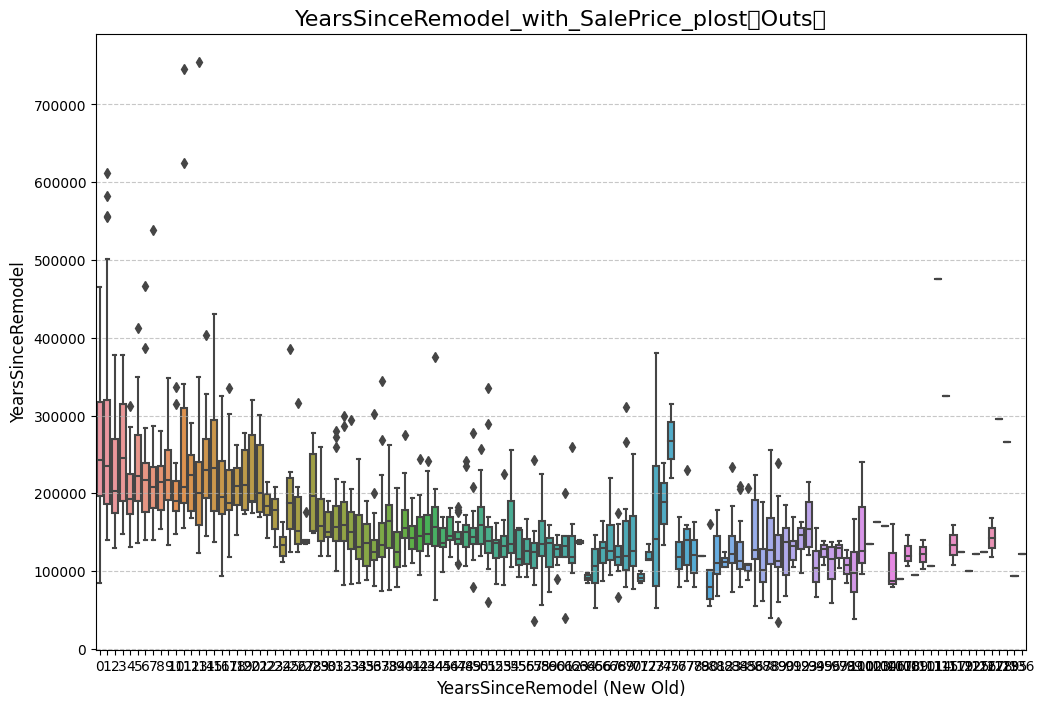

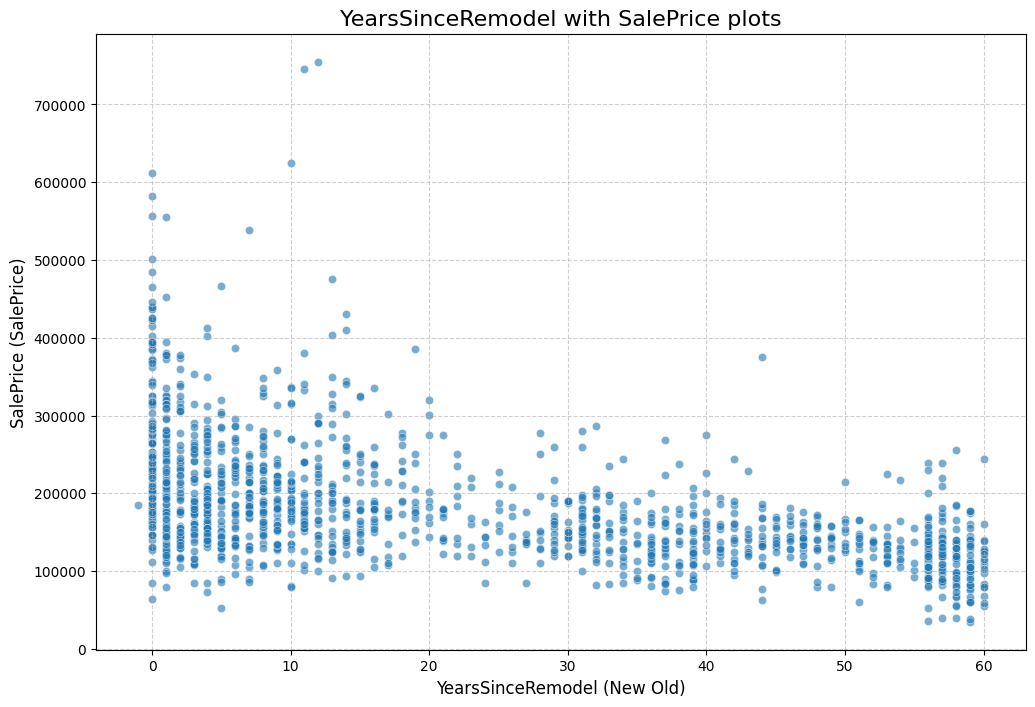

In [338]:
# --- グラフ描画のためのデータ準備 ---
# x_train と y_train をグラフ描画のために一時的に結合します。
# これにより、'YearsSinceRemodel' と 'SalePrice' を同時に扱えるようになります。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- グラフの描画 (箱ひげ図) ---
print("\n--- グラフを生成します ---")
plt.figure(figsize=(12, 8)) # グラフのサイズを大きめに設定

sns.boxplot(x='Age', y='SalePrice', data=plotting_data)

# グラフのタイトルとラベルを設定
plt.title('YearsSinceRemodel_with_SalePrice_plost（Outs）', fontsize=16)
plt.xlabel('YearsSinceRemodel (New Old)', fontsize=12)
plt.ylabel('YearsSinceRemodel', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- 補足：散布図による確認 ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='YearsSinceRemodel', y='SalePrice', data=plotting_data, alpha=0.6)
plt.title('YearsSinceRemodel with SalePrice plots', fontsize=16)
plt.xlabel('YearsSinceRemodel (New Old)', fontsize=12)
plt.ylabel('SalePrice (SalePrice)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

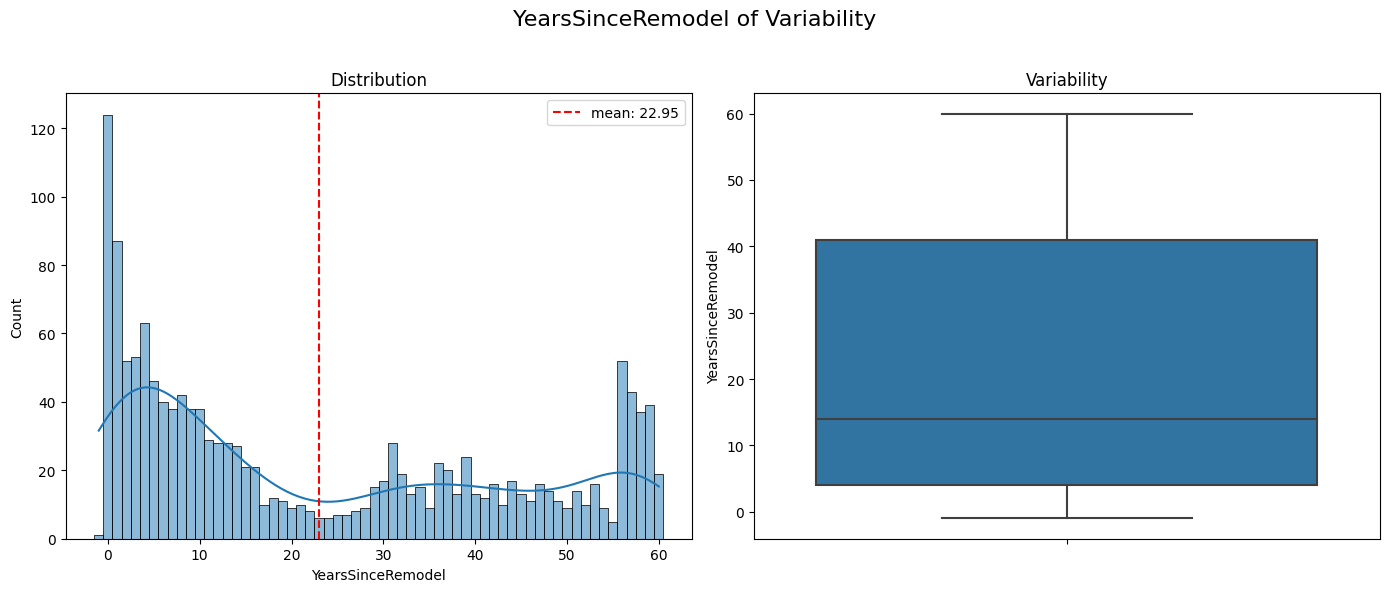


--- 基本的な統計情報 (describe) ---
count    1460.000000
mean       22.950000
std        20.640653
min        -1.000000
25%         4.000000
50%        14.000000
75%        41.000000
max        60.000000
Name: YearsSinceRemodel, dtype: float64


In [339]:
qual_series = x_train['YearsSinceRemodel']

# 平均値と標準偏差を計算
mean_val = qual_series.mean()
std_val = qual_series.std()


# --- ばらつきをグラフで確認 ---
# グラフを2つ並べるための設定
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('YearsSinceRemodel of Variability', fontsize=16)


# 1. 左側のグラフ: ヒストグラム
sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
axes[0].set_title('Distribution')
axes[0].set_xlabel('YearsSinceRemodel')
axes[0].set_ylabel('Count')
# 平均値の場所に縦線を引く
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
axes[0].legend()


# 2. 右側のグラフ: 箱ひげ図
sns.boxplot(y=qual_series, ax=axes[1])
axes[1].set_title('Variability')
axes[1].set_ylabel('YearsSinceRemodel')


# グラフを表示
plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
plt.show()


# --- 参考：統計情報の表示 ---
print("\n--- 基本的な統計情報 (describe) ---")
# .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
print(qual_series.describe())

In [340]:
# --- 1. グラフと計算のためのデータ準備 ---
# x_train と y_train を一時的に結合します。
plotting_data = pd.concat([x_train, y_train], axis=1)


# --- 2. 外れ値の計算 ---
# OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
Q1 = plotting_data.groupby('YearsSinceRemodel')['SalePrice'].quantile(0.25)
Q3 = plotting_data.groupby('YearsSinceRemodel')['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の境界線（下限と上限）を計算
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 計算結果を一つのデータフレームにまとめる
outlier_stats = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})
print("\n--- YearsSinceRemodelごとの外れ値の境界線 ---")
print(outlier_stats)


# --- 3. 外れ値の特定と件数の表示 ---
# 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# 各行ごとに判定するため、ここではループやapplyを使います。

outliers_list = []
for index, row in plotting_data.iterrows():
    qual = row['YearsSinceRemodel']
    price = row['SalePrice']
    
    # その行の品質レベルに対応する境界線を取得
    bounds = outlier_stats.loc[qual]
    
    # 境界線の外にあるかどうかをチェック
    if price < bounds['lower_bound'] or price > bounds['upper_bound']:
        outliers_list.append(row)

# 外れ値のリストを新しいデータフレームに変換
outliers_df = pd.DataFrame(outliers_list)


print(f"\n--- 外れ値の件数 ---")
print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# YearsSinceRemodelごとに何件の外れ値があったかを表示
print("\n--- YearsSinceRemodelごとの外れ値の件数 ---")
print(outliers_df['YearsSinceRemodel'].value_counts().sort_index())


--- YearsSinceRemodelごとの外れ値の境界線 ---
                          Q1        Q3        IQR  lower_bound  upper_bound
YearsSinceRemodel                                                          
-1                 184750.00  184750.0       0.00   184750.000   184750.000
 0                 187687.50  325381.0  137693.50   -18852.750   531921.250
 1                 150750.00  275250.0  124500.00   -36000.000   462000.000
 2                 148762.50  257850.0  109087.50   -14868.750   421481.250
 3                 154500.00  250000.0   95500.00    11250.000   393250.000
 4                 155500.00  245000.0   89500.00    21250.000   379250.000
 5                 135375.00  224550.0   89175.00     1612.500   358312.500
 6                 143000.00  237671.5   94671.50      992.750   379678.750
 7                 168875.00  218750.0   49875.00    94062.500   293562.500
 8                 163250.00  246625.0   83375.00    38187.500   371687.500
 9                 155358.50  216500.0   61141.50  

# 新築フラグの追加(IsNew はOverallQual で説明済みであり、精度が全く変わらなかったので、削除)

In [341]:

#x_train['IsNew'] = (train_df['YearBuilt'] == train_df['YrSold']).astype(int)
#x_test['IsNew'] = (test['YearBuilt'] == test['YrSold']).astype(int)



In [342]:
# x_trainに'OverallQual'があると仮定
#print(x_train.groupby('IsNew')['OverallQual'].describe())

In [343]:
# --- IsNew はOverallQual で説明済みであり、精度が全く変わらなかったので、削除した---
# x_train から 'IsNew' 列を削除
#x_train.drop('IsNew', axis=1, inplace=True, errors='ignore')

# x_test から 'IsNew' 列を削除
#x_test.drop('IsNew', axis=1, inplace=True, errors='ignore')
# -------

# TotalBsmtSF2の作成 = df['1stFlrSF'] + df['2ndFlrSF']）

In [344]:
x_train['TotalBsmtSF2'] = train_df2['1stFlrSF'] + test2['2ndFlrSF']
x_test['TotalBsmtSF2'] = test2['1stFlrSF'] + test2['2ndFlrSF']

In [345]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['TotalBsmtSF2'] = scaler.fit_transform(x_train[['TotalBsmtSF2']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['TotalBsmtSF2'] = scaler.transform(x_test[['TotalBsmtSF2']])

In [346]:
 # print(x_train['TotalBsmtSF2'].dtype)
 # print(x_train['TotalBsmtSF2'].unique())

In [347]:
#データフレームから直接計算
# データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['TotalBsmtSF2'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [348]:
# qual_series = x_train['TotalBsmtSF2']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('TotalBsmtSF2 of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('TotalBsmtSF')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('TotalBsmtSF2')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [349]:
# # --- 1. グラフと計算のためのデータ準備 ---
# # x_train と y_train を一時的に結合します。
# plotting_data = pd.concat([x_train, y_train], axis=1)


# # --- 2. 外れ値の計算 ---
# # OverallQual の各カテゴリごとに、Q1, Q3, IQR を計算
# Q1 = plotting_data.groupby('TotalBsmtSF')['SalePrice'].quantile(0.25)
# Q3 = plotting_data.groupby('TotalBsmtSF')['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# # 外れ値の境界線（下限と上限）を計算
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # 計算結果を一つのデータフレームにまとめる
# outlier_stats = pd.DataFrame({
#     'Q1': Q1,
#     'Q3': Q3,
#     'IQR': IQR,
#     'lower_bound': lower_bound,
#     'upper_bound': upper_bound
# })
# print("\n--- TotalBsmtSFごとの外れ値の境界線 ---")
# print(outlier_stats)


# # --- 3. 外れ値の特定と件数の表示 ---
# # 各行のデータが、そのOverallQualカテゴリの境界線の外にあるかどうかを判定
# # .any() は、1行でもTrueがあればTrueを返すので、ここでは使いません。
# # 各行ごとに判定するため、ここではループやapplyを使います。

# outliers_list = []
# for index, row in plotting_data.iterrows():
#     qual = row['TotalBsmtSF']
#     price = row['SalePrice']
    
#     # その行の品質レベルに対応する境界線を取得
#     bounds = outlier_stats.loc[qual]
    
#     # 境界線の外にあるかどうかをチェック
#     if price < bounds['lower_bound'] or price > bounds['upper_bound']:
#         outliers_list.append(row)

# # 外れ値のリストを新しいデータフレームに変換
# outliers_df = pd.DataFrame(outliers_list)


# print(f"\n--- 外れ値の件数 ---")
# print(f"合計 {len(outliers_df)} 件の外れ値が検出されました。")

# # YearsSinceRemodelごとに何件の外れ値があったかを表示
# print("\n--- TotalBsmtSFごとの外れ値の件数 ---")
# print(outliers_df['TotalBsmtSF'].value_counts().sort_index())

In [350]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['TotalBsmtSF2'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalBsmtSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

# TotalSF （TotalBsmtSF + 1stFlrSF + 2ndFlrSF）の作成

In [351]:
x_train['TotalBsmtSF3'] = train_df2['1stFlrSF'] + test2['2ndFlrSF']
x_test['TotalBsmtSF3'] = test2['1stFlrSF'] + test2['2ndFlrSF']

In [352]:
x_train['TotalSF'] = train_df2['1stFlrSF'] + test2['2ndFlrSF'] + x_train['TotalBsmtSF3']
x_test['TotalSF'] = test2['1stFlrSF'] + test2['2ndFlrSF'] + x_test['TotalBsmtSF3']

In [353]:
x_train.drop('TotalBsmtSF2', axis=1, inplace=True)
x_test.drop('TotalBsmtSF2', axis=1, inplace=True)

In [354]:
x_train.drop('TotalBsmtSF3', axis=1, inplace=True)
x_test.drop('TotalBsmtSF3', axis=1, inplace=True)

In [355]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['TotalSF'] = scaler.fit_transform(x_train[['TotalSF']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['TotalSF'] = scaler.transform(x_test[['TotalSF']])

In [356]:
x_train.head()

,SaleCondition,FullBath,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF
0,0,2,3,6,2,5,-0.254076,3,8,0.380070,-0.453608,7,2.0,2.0,0.0,5.0,0.452790,4,1,2,3,2,2.0,0.281573,5,5,5,-0.682809
1,0,2,3,6,2,6,0.030015,3,6,-0.312090,0.343643,6,2.0,2.0,3.0,4.0,0.834679,4,1,2,2,1,2.0,-0.082816,8,31,31,-0.191283
2,0,2,3,6,2,5,0.437624,3,6,0.497489,-0.327933,7,2.0,2.0,1.0,5.0,0.143910,4,1,2,3,2,2.0,0.530021,5,7,6,0.243341
3,1,1,3,6,2,6,0.017663,2,7,0.390885,-0.247423,7,1.0,3.0,0.0,4.0,-0.235170,3,1,2,3,1,3.0,0.670807,5,91,36,0.265133
4,0,2,3,6,2,7,1.181201,3,9,1.134029,0.113893,8,2.0,2.0,2.0,5.0,0.381186,4,1,2,3,2,3.0,1.474120,5,8,8,-0.332930


## 'OverallGrade'] = df['OverallQual'] * df['OverallCond'] の作成

In [357]:
print(train_df['OverallQual'].dtype)
print(train_df['OverallQual'].unique())

int64
[ 7  6  8  5  9  4 10  3  1  2]


In [358]:
print(test['OverallQual'].dtype)
print(test['OverallQual'].unique())

int64
[ 5  6  8  7  4  9  2  3 10  1]


In [359]:
missing_count = train_df['OverallQual'].isna().sum()
print(f"'OverallQual(学習用）' の欠損値件数: {missing_count} 件")

'OverallQual(学習用）' の欠損値件数: 0 件


In [360]:
missing_count = test['OverallQual'].isna().sum()
print(f"'OverallQual(test用）' の欠損値件数: {missing_count} 件")

'OverallQual(test用）' の欠損値件数: 0 件


In [361]:
print(train_df['OverallCond'].dtype)
print(train_df['OverallCond'].unique())

int64
[5 8 6 7 4 2 3 9 1]


In [362]:
print(test['OverallCond'].dtype)
print(test['OverallCond'].unique())

int64
[6 5 7 8 2 9 3 4 1]


In [363]:
missing_count = train_df['OverallCond'].isna().sum()
print(f"'OverallCond(学習用）' の欠損値件数: {missing_count} 件")

'OverallCond(学習用）' の欠損値件数: 0 件


In [364]:
missing_count = test['OverallCond'].isna().sum()
print(f"'OverallCond(test用）' の欠損値件数: {missing_count} 件")

'OverallCond(test用）' の欠損値件数: 0 件


In [365]:
x_train['OverallGrade'] = train_df['OverallQual'] * train_df['OverallCond']
x_test['OverallGrade'] = test['OverallQual'] * test['OverallCond']

In [366]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます
correlation = x_train['OverallGrade'].corr(df_1['SalePrice'])

print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
print(correlation)

CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:
0.5652938448019194


In [367]:
# qual_series = x_train['OverallGrade']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('OverallGrade of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('OverallGrade')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('OverallGrade')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [368]:
# 学習用データの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_train['OverallGrade'].skew()


# --- 2. 結果の表示 ---
print(f" OverallGradeの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 OverallGradeの歪度(学習用): 0.4377
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。


In [369]:
print(x_test['OverallGrade'].dtype)
print(x_test['OverallGrade'].unique())

int64
[30 36 25 40 42 35 20 45 48 28  4 72 15 49 12 16 24 18 10 50 64 56 32 63
 54  8  9  5 27  3  2  6]


In [370]:
print(x_train['OverallGrade'].dtype)
print(x_train['OverallGrade'].unique())

int64
[35 48 40 25 42 30 45 56 20 49 24 16 36 50 28 18  6 15 90 64 63 32 12  1
 10 21  3  9  8 60 54 72]


In [371]:
missing_count = x_train['OverallGrade'].isna().sum()
print(f"'OverallGrade(学習用）' の欠損値件数: {missing_count} 件")

'OverallGrade(学習用）' の欠損値件数: 0 件


In [372]:
missing_count = x_test['OverallGrade'].isna().sum()
print(f"'OverallGrade(test用）' の欠損値件数: {missing_count} 件")

'OverallGrade(test用）' の欠損値件数: 0 件


# TotalBath の追加　とまとめてカラム表示、欠損値を最頻値で埋めた例

In [373]:
cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = train_df[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'FullBath' の欠損値件数: 0 件
'HalfBath' の欠損値件数: 0 件
'BsmtFullBath' の欠損値件数: 0 件
'BsmtHalfBath' の欠損値件数: 0 件


In [374]:
cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = test[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'FullBath' の欠損値件数: 0 件
'HalfBath' の欠損値件数: 0 件
'BsmtFullBath' の欠損値件数: 2 件
'BsmtHalfBath' の欠損値件数: 2 件


In [375]:
cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = train_df[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = train_df[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'FullBath'
  データ型: int64
  ユニークな値: [2 1 3 0]
-----------------------------------------
カラム名: 'HalfBath'
  データ型: int64
  ユニークな値: [1 0 2]
-----------------------------------------
カラム名: 'BsmtFullBath'
  データ型: int64
  ユニークな値: [1 0 2 3]
-----------------------------------------
カラム名: 'BsmtHalfBath'
  データ型: int64
  ユニークな値: [0 1 2]


In [376]:
cols_to_check = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = test[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = test[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'FullBath'
  データ型: int64
  ユニークな値: [1 2 3 4 0]
-----------------------------------------
カラム名: 'HalfBath'
  データ型: int64
  ユニークな値: [0 1 2]
-----------------------------------------
カラム名: 'BsmtFullBath'
  データ型: float64
  ユニークな値: [ 0.  1.  2.  3. nan]
-----------------------------------------
カラム名: 'BsmtHalfBath'
  データ型: float64
  ユニークな値: [ 0.  1. nan  2.]


In [377]:
# 1. 学習データ(x_train)の最頻値を計算する
# .mode()は最頻値をSeriesとして返すため、[0]で最初の値(最も頻度が高い値)を取得
mode_value = test['BsmtFullBath'].mode()[0]

# 2. 計算した最頻値で、テストデータ(x_test)の欠損値を埋める
# .fillna() を使います。inplace=Trueで元のDataFrameを直接変更します。
test['BsmtFullBath'].fillna(mode_value, inplace=True)

print(f"\testデータの'BsmtFullBath'の最頻値は: {mode_value}")

# print("\n--- 処理後の test ---")
# print(test['BsmtFullBath'])

print("\n--- 処理後の x_test の欠損値 ---")
# 欠損値が0になっていることを確認
print(test['BsmtFullBath'].isna().sum())

	estデータの'BsmtFullBath'の最頻値は: 0.0

--- 処理後の x_test の欠損値 ---
0


In [378]:
# 1. 学習データ(x_train)の最頻値を計算する
# .mode()は最頻値をSeriesとして返すため、[0]で最初の値(最も頻度が高い値)を取得
mode_value = test['BsmtHalfBath'].mode()[0]

# 2. 計算した最頻値で、テストデータ(x_test)の欠損値を埋める
# .fillna() を使います。inplace=Trueで元のDataFrameを直接変更します。
test['BsmtHalfBath'].fillna(mode_value, inplace=True)

print(f"\n学習データの'BsmtHalfBath'の最頻値は: {mode_value}")

# print("\n--- 処理後の test ---")
# print(test['BsmtFullBath'])

print("\n--- 処理後の x_test の欠損値 ---")
# 欠損値が0になっていることを確認
print(test['BsmtHalfBath'].isna().sum())


学習データの'BsmtHalfBath'の最頻値は: 0.0

--- 処理後の x_test の欠損値 ---
0


In [379]:
x_train['TotalBath'] = train_df['FullBath'] + (0.5 * train_df['HalfBath']) + \
                  train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath'])

In [380]:
x_test['TotalBath'] = test['FullBath'] + (0.5 * test['HalfBath']) + \
                  test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])

In [381]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます
correlation = x_train['TotalBath'].corr(df_1['SalePrice'])

print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
print(correlation)

CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:
0.6317310679319873


In [382]:
# 学習用データの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_train['TotalBath'].skew()


# --- 2. 結果の表示 ---
print(f" TotalBathの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 TotalBathの歪度(学習用): 0.2647
-----------------------------------------
【歪度の目安】
 -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。


In [383]:
# testデータの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_test['TotalBath'].skew()


# --- 2. 結果の表示 ---
print(f" TotalBathの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 TotalBathの歪度(学習用): 0.6808
-----------------------------------------
【歪度の目安】
 -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。


In [384]:
# qual_series = x_test['TotalBath']

# # 平均値と標準偏差を計算
# mean_val = qual_series.mean()
# std_val = qual_series.std()


# # --- ばらつきをグラフで確認 ---
# # グラフを2つ並べるための設定
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('TotalBath of Variability', fontsize=16)


# # 1. 左側のグラフ: ヒストグラム
# sns.histplot(qual_series, kde=True, ax=axes[0], bins=10, discrete=True)
# axes[0].set_title('Distribution')
# axes[0].set_xlabel('TotalBath')
# axes[0].set_ylabel('Count')
# # 平均値の場所に縦線を引く
# axes[0].axvline(mean_val, color='red', linestyle='--', label=f'mean: {mean_val:.2f}')
# axes[0].legend()


# # 2. 右側のグラフ: 箱ひげ図
# sns.boxplot(y=qual_series, ax=axes[1])
# axes[1].set_title('Variability')
# axes[1].set_ylabel('TotalBath')


# # グラフを表示
# plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitleと重ならないように調整
# plt.show()


# # --- 参考：統計情報の表示 ---
# print("\n--- 基本的な統計情報 (describe) ---")
# # .describe() を使うと、平均、標準偏差、最小値、最大値などを一覧で確認できます。
# print(qual_series.describe())

In [385]:
drop_cols = ['FullBath']

# x_trainとx_testの両方から削除
x_train.drop(drop_cols, axis=1, inplace=True, errors='ignore')
x_test.drop(drop_cols, axis=1, inplace=True, errors='ignore')

# Overall_and_GrLiv= OverallQual_x_GrLivArea の追加

In [386]:
cols_to_check = ['OverallQual', 'GrLivArea']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = train_df[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = train_df[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'OverallQual'
  データ型: int64
  ユニークな値: [ 7  6  8  5  9  4 10  3  1  2]
-----------------------------------------
カラム名: 'GrLivArea'
  データ型: int64
  ユニークな値の数: 861 個


In [387]:
cols_to_check = ['OverallQual', 'GrLivArea']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = test[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = test[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'OverallQual'
  データ型: int64
  ユニークな値: [ 5  6  8  7  4  9  2  3 10  1]
-----------------------------------------
カラム名: 'GrLivArea'
  データ型: int64
  ユニークな値の数: 879 個


In [388]:
cols_to_check = ['OverallQual', 'GrLivArea']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = train_df[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'OverallQual' の欠損値件数: 0 件
'GrLivArea' の欠損値件数: 0 件


In [389]:
cols_to_check = ['OverallQual', 'GrLivArea']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = test[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'OverallQual' の欠損値件数: 0 件
'GrLivArea' の欠損値件数: 0 件


In [390]:
x_train['OverallQual_x_GrLivArea'] = train_df['OverallQual'] * train_df['GrLivArea']

In [391]:
x_test['OverallQual_x_GrLivArea'] = test['OverallQual'] * test['GrLivArea']

In [392]:
cols_to_check = ['OverallQual_x_GrLivArea']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = x_train[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'OverallQual_x_GrLivArea' の欠損値件数: 0 件


In [393]:
cols_to_check = ['OverallQual_x_GrLivArea']

print("--- 各カラムの欠損値件数（ループ処理） ---")
for col_name in cols_to_check:
    # あなたのコードをループ内で使用
    missing_count = x_test[col_name].isna().sum()
    print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'OverallQual_x_GrLivArea' の欠損値件数: 0 件


In [394]:
##参考

# スケーラーのインスタンスを作成
scaler = RobustScaler()

# 1. 学習データに対して fit + transform（学習＋変換）
x_train['OverallQual_x_GrLivArea'] = scaler.fit_transform(x_train[['OverallQual_x_GrLivArea']])

# 2. テストデータに対して transform のみ（同じスケール基準で変換）
x_test['OverallQual_x_GrLivArea'] = scaler.transform(x_test[['OverallQual_x_GrLivArea']])

In [395]:
cols_to_check = ['OverallQual_x_GrLivArea']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = x_train[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = x_train[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'OverallQual_x_GrLivArea'
  データ型: float64
  ユニークな値の数: 1133 個


In [396]:
cols_to_check = ['OverallQual_x_GrLivArea']

print("--- 各カラムのデータ型とユニークな値 ---")
for col_name in cols_to_check:
    print("-----------------------------------------")
    print(f"カラム名: '{col_name}'")
    
    # 1. データ型 (dtype) を表示
    dtype = x_test[col_name].dtype
    print(f"  データ型: {dtype}")
    
    # 2. ユニークな値 (unique values) を表示
    unique_values = x_test[col_name].unique()
    
    # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
    if len(unique_values) > 15:
        print(f"  ユニークな値の数: {len(unique_values)} 個")
    else:
        print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'OverallQual_x_GrLivArea'
  データ型: float64
  ユニークな値の数: 1151 個


In [397]:
#データフレームから直接計算
# データをDataFrameとして読み込む
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# 【正しいコード】
# df['列名'] の形は pandas Series なので、.corr() が使えます
correlation = x_train['OverallQual_x_GrLivArea'].corr(df_1['SalePrice'])

print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
print(correlation)

CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:
0.8320574514356203


In [398]:
# 学習データの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_train['OverallQual_x_GrLivArea'].skew()


# --- 2. 結果の表示 ---
print(f" OverallQual_x_GrLivAreaの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 OverallQual_x_GrLivAreaの歪度(学習用): 2.0189
-----------------------------------------
【歪度の目安】
 -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。


In [399]:
# testデータの歪度を調べる
# --- 1. 'FullBath' の歪度を計算 ---
skewness = x_test['OverallQual_x_GrLivArea'].skew()


# --- 2. 結果の表示 ---
print(f" OverallQual_x_GrLivAreaの歪度(学習用): {skewness:.4f}")
print("-----------------------------------------")


# --- 歪度の解釈 ---
print("【歪度の目安】")
if -0.5 <= skewness <= 0.5:
    print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
elif skewness > 0.5:
    print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
else: # skewness < -0.5
    print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

 OverallQual_x_GrLivAreaの歪度(学習用): 1.5343
-----------------------------------------
【歪度の目安】
 -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。


# TotalPorchSF = OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch の作成

In [400]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = train_df[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = train_df[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [401]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

In [402]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = train_df[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [403]:
# cols_to_check = ['OpenPorchSF', 'EnclosedPorch' , '3SsnPorch' , 'ScreenPorch']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

In [404]:
# x_train['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
# x_test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

In [405]:
# ##参考

# # スケーラーのインスタンスを作成
# scaler = RobustScaler()

# # 1. 学習データに対して fit + transform（学習＋変換）
# x_train['TotalPorchSF'] = scaler.fit_transform(x_train[['TotalPorchSF']])

# # 2. テストデータに対して transform のみ（同じスケール基準で変換）
# x_test['TotalPorchSF'] = scaler.transform(x_test[['TotalPorchSF']])

In [406]:
# #データフレームから直接計算
# # データをDataFrameとして読み込む
# df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# # 【正しいコード】
# # df['列名'] の形は pandas Series なので、.corr() が使えます
# correlation = x_train['TotalPorchSF'].corr(df_1['SalePrice'])

# print("CSV→上記でx_trainに追加したデータフレームで直接計算した相関係数:")
# print(correlation)

In [407]:
# # 学習用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_train['TotalPorchSF'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalPorchSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [408]:
# # test用データの歪度を調べる
# # --- 1. 'FullBath' の歪度を計算 ---
# skewness = x_test['TotalPorchSF'].skew()


# # --- 2. 結果の表示 ---
# print(f" TotalPorchSFの歪度(学習用): {skewness:.4f}")
# print("-----------------------------------------")


# # --- 歪度の解釈 ---
# print("【歪度の目安】")
# if -0.5 <= skewness <= 0.5:
#     print(" -> ほぼ左右対称な分布で対数変換は不要の可能性が大です。")
# elif skewness > 0.5:
#     print(" -> 右に裾が長い（右に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")
# else: # skewness < -0.5
#     print(" -> 左に裾が長い（左に歪んだ）分布です。データの種類と性質に応じて対数変換をお勧めします。")

In [409]:
# for df in [x_train, x_test]:
#     if 'TotalPorchSF' in df.columns:
#         df.drop(columns='TotalPorchSF', inplace=True)

 # df['HasGarage'] = (df['GarageArea'] > 0).astype(int)　の追加　ガレージあるなし

In [410]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_train[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_train[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'GarageArea'
  データ型: float64
  ユニークな値の数: 441 個


In [411]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムのデータ型とユニークな値 ---")
# for col_name in cols_to_check:
#     print("-----------------------------------------")
#     print(f"カラム名: '{col_name}'")
    
#     # 1. データ型 (dtype) を表示
#     dtype = x_test[col_name].dtype
#     print(f"  データ型: {dtype}")
    
#     # 2. ユニークな値 (unique values) を表示
#     unique_values = x_test[col_name].unique()
    
#     # ユニークな値が多すぎる場合(例: 15個以上)は、件数だけ表示するように工夫
#     if len(unique_values) > 15:
#         print(f"  ユニークな値の数: {len(unique_values)} 個")
#     else:
#         print(f"  ユニークな値: {unique_values}")

--- 各カラムのデータ型とユニークな値 ---
-----------------------------------------
カラム名: 'GarageArea'
  データ型: float64
  ユニークな値の数: 460 個


In [412]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_train[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'GarageArea' の欠損値件数: 0 件


In [413]:
# cols_to_check = ['GarageArea']

# print("--- 各カラムの欠損値件数（ループ処理） ---")
# for col_name in cols_to_check:
#     # あなたのコードをループ内で使用
#     missing_count = x_test[col_name].isna().sum()
#     print(f"'{col_name}' の欠損値件数: {missing_count} 件")

--- 各カラムの欠損値件数（ループ処理） ---
'GarageArea' の欠損値件数: 1 件


In [414]:
x_train.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF,OverallGrade,TotalBath,OverallQual_x_GrLivArea
0,0,3,6,2,5,-0.254076,3,8,0.380070,-0.453608,7,2.0,2.0,0.0,5.0,0.452790,4,1,2,3,2,2.0,0.281573,5,5,5,-0.682809,35,3.5,0.492958
1,0,3,6,2,6,0.030015,3,6,-0.312090,0.343643,6,2.0,2.0,3.0,4.0,0.834679,4,1,2,2,1,2.0,-0.082816,8,31,31,-0.191283,48,2.5,-0.195305
2,0,3,6,2,5,0.437624,3,6,0.497489,-0.327933,7,2.0,2.0,1.0,5.0,0.143910,4,1,2,3,2,2.0,0.530021,5,7,6,0.243341,35,3.5,0.576213
3,1,3,6,2,6,0.017663,2,7,0.390885,-0.247423,7,1.0,3.0,0.0,4.0,-0.235170,3,1,2,3,1,3.0,0.670807,5,91,36,0.265133,35,2.0,0.500626
4,0,3,6,2,7,1.181201,3,9,1.134029,0.113893,8,2.0,2.0,2.0,5.0,0.381186,4,1,2,3,2,3.0,1.474120,5,8,8,-0.332930,40,3.5,1.371518


In [415]:
# x_train['HasGarage'] = (train_df['GarageArea'] > 0).astype(int)
# x_test['HasGarage'] = (test['GarageArea'] > 0).astype(int) 

In [453]:
# for df in [x_train, x_test]:
#     if 'HasGarage' in df.columns:
#         df.drop(columns='HasGarage', inplace=True)

# Outlier_Flag をカラムから削除

In [416]:
for df in [x_train, x_test]:
    if 'Outlier_Flag' in df.columns:
        df.drop(columns='Outlier_Flag', inplace=True)

## 処理後のデータフレーム全体の確認

In [417]:
# #pandas のデフォルト表示幅制限を解除↓
# #学習用データの種類数 現状
# summary = pd.DataFrame({
#     '種類数': [x_train[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_train[col].dropna().unique()[:13] for col in features]  # 最大5種表示
# }, index=features)

# with pd.option_context('display.max_colwidth', None):
#     display(summary)


# summary

In [418]:
# #pandas のデフォルト表示幅制限を解除↓
# #テスト用データの種類数 現状
# summary = pd.DataFrame({
#     '種類数': [x_test[col].nunique(dropna=True) for col in features],
#     'サンプル値': [x_test[col].dropna().unique()[:13] for col in features]  # 最大5種表示
# }, index=features)

# with pd.option_context('display.max_colwidth', None):
#     display(summary)


# summary

In [419]:
x_train_backup.head()

,SaleCondition,FullBath,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond
0,Normal,2,WD,Typ,RL,CollgCr,8450,60,8,1710,856,7,Gd,TA,No,GLQ,706,Ex,Y,1,Gd,Gd,2,548,5
1,Normal,2,WD,Typ,RL,Veenker,9600,20,6,1262,1262,6,Gd,TA,Gd,ALQ,978,Ex,Y,1,TA,TA,2,460,8
2,Normal,2,WD,Typ,RL,CollgCr,11250,60,6,1786,920,7,Gd,TA,Mn,GLQ,486,Ex,Y,1,Gd,Gd,2,608,5
3,Abnorml,1,WD,Typ,RL,Crawfor,9550,70,7,1717,961,7,TA,Gd,No,ALQ,216,Gd,Y,1,Gd,TA,3,642,5
4,Normal,2,WD,Typ,RL,NoRidge,14260,60,9,2198,1145,8,Gd,TA,Av,GLQ,655,Ex,Y,1,Gd,Gd,3,836,5


In [420]:
x_train.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF,OverallGrade,TotalBath,OverallQual_x_GrLivArea,HasGarage
0,0,3,6,2,5,-0.254076,3,8,0.380070,-0.453608,7,2.0,2.0,0.0,5.0,0.452790,4,1,2,3,2,2.0,0.281573,5,5,5,-0.682809,35,3.5,0.492958,1
1,0,3,6,2,6,0.030015,3,6,-0.312090,0.343643,6,2.0,2.0,3.0,4.0,0.834679,4,1,2,2,1,2.0,-0.082816,8,31,31,-0.191283,48,2.5,-0.195305,1
2,0,3,6,2,5,0.437624,3,6,0.497489,-0.327933,7,2.0,2.0,1.0,5.0,0.143910,4,1,2,3,2,2.0,0.530021,5,7,6,0.243341,35,3.5,0.576213,1
3,1,3,6,2,6,0.017663,2,7,0.390885,-0.247423,7,1.0,3.0,0.0,4.0,-0.235170,3,1,2,3,1,3.0,0.670807,5,91,36,0.265133,35,2.0,0.500626,1
4,0,3,6,2,7,1.181201,3,9,1.134029,0.113893,8,2.0,2.0,2.0,5.0,0.381186,4,1,2,3,2,3.0,1.474120,5,8,8,-0.332930,40,3.5,1.371518,1


In [421]:
x_test_backup.head()

,SaleCondition,FullBath,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond
0,Normal,1,WD,Typ,RH,NAmes,11622,20,5,896,896,5,TA,TA,No,Rec,468.0,TA,Y,1,TA,TA,1.0,730.0,6
1,Normal,1,WD,Typ,RL,NAmes,14267,20,6,1329,1329,6,TA,TA,No,ALQ,923.0,TA,Y,1,Gd,TA,1.0,312.0,6
2,Normal,2,WD,Typ,RL,Gilbert,13830,60,6,1629,928,5,Gd,TA,No,GLQ,791.0,Gd,Y,1,TA,TA,2.0,482.0,5
3,Normal,2,WD,Typ,RL,Gilbert,9978,60,7,1604,926,6,TA,TA,No,GLQ,602.0,Ex,Y,1,Gd,TA,2.0,470.0,6
4,Normal,2,WD,Typ,RL,StoneBr,5005,120,5,1280,1280,8,Gd,TA,No,ALQ,263.0,Ex,Y,1,Gd,Gd,2.0,506.0,5


In [422]:
x_test.head()

,SaleCondition,SaleType,Functional,MSZoning,Neighborhood,LotArea,MSSubClass,TotRmsAbvGrd,GrLivArea,1stFlrSF,OverallQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,HeatingQC,CentralAir,KitchenAbvGr,KitchenQual,ExterQual,GarageCars,GarageArea,OverallCond,Age,YearsSinceRemodel,TotalSF,OverallGrade,TotalBath,OverallQual_x_GrLivArea,HasGarage
0,0,3.0,6.0,1.0,4,0.529521,3,5,-0.877559,-0.375061,5,1.0,2.0,0.0,2.0,0.118638,2,1,2,2.0,1,1.0,1.035197,6,49,49,-0.634383,30,1.0,-0.679186,1
1,0,3.0,6.0,2.0,4,1.182930,3,6,-0.208575,0.475209,6,1.0,2.0,0.0,4.0,0.757459,2,1,2,3.0,1,1.0,-0.695652,6,52,52,-0.110169,36,1.5,-0.132394,1
2,0,3.0,6.0,2.0,5,1.074975,3,6,0.254925,-0.312224,5,2.0,2.0,0.0,5.0,0.572131,3,1,2,2.0,1,2.0,0.008282,5,13,12,0.253027,25,2.5,-0.105634,1
3,0,3.0,6.0,2.0,5,0.123394,3,7,0.216300,-0.316151,6,1.0,2.0,0.0,5.0,0.306774,4,1,2,3.0,1,2.0,-0.041408,6,12,12,0.222760,36,2.5,0.125822,1
4,0,3.0,6.0,2.0,7,-1.105114,1,5,-0.284280,0.378989,8,2.0,2.0,0.0,4.0,-0.169182,4,1,2,3.0,2,2.0,0.107660,5,18,18,-0.169492,40,2.0,0.222222,1


In [423]:
x_train_backup.dtypes

SaleCondition    object
FullBath          int64
SaleType         object
Functional       object
MSZoning         object
Neighborhood     object
LotArea           int64
MSSubClass        int64
TotRmsAbvGrd      int64
GrLivArea         int64
1stFlrSF          int64
OverallQual       int64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1        int64
HeatingQC        object
CentralAir       object
KitchenAbvGr      int64
KitchenQual      object
ExterQual        object
GarageCars        int64
GarageArea        int64
OverallCond       int64
dtype: object

In [424]:
x_train.dtypes

SaleCondition                int64
SaleType                     int64
Functional                   int64
MSZoning                     int64
Neighborhood                 int64
LotArea                    float64
MSSubClass                   int64
TotRmsAbvGrd                 int64
GrLivArea                  float64
1stFlrSF                   float64
OverallQual                  int64
BsmtQual                   float64
BsmtCond                   float64
BsmtExposure               float64
BsmtFinType1               float64
BsmtFinSF1                 float64
HeatingQC                    int64
CentralAir                   int64
KitchenAbvGr                 int64
KitchenQual                  int64
ExterQual                    int64
GarageCars                 float64
GarageArea                 float64
OverallCond                  int64
Age                          int64
YearsSinceRemodel            int64
TotalSF                    float64
OverallGrade                 int64
TotalBath           

In [425]:
x_test_backup.dtypes

SaleCondition     object
FullBath           int64
SaleType          object
Functional        object
MSZoning          object
Neighborhood      object
LotArea            int64
MSSubClass         int64
TotRmsAbvGrd       int64
GrLivArea          int64
1stFlrSF           int64
OverallQual        int64
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
HeatingQC         object
CentralAir        object
KitchenAbvGr       int64
KitchenQual       object
ExterQual         object
GarageCars       float64
GarageArea       float64
OverallCond        int64
dtype: object

In [426]:
x_test.dtypes

SaleCondition                int64
SaleType                   float64
Functional                 float64
MSZoning                   float64
Neighborhood                 int64
LotArea                    float64
MSSubClass                   int64
TotRmsAbvGrd                 int64
GrLivArea                  float64
1stFlrSF                   float64
OverallQual                  int64
BsmtQual                   float64
BsmtCond                   float64
BsmtExposure               float64
BsmtFinType1               float64
BsmtFinSF1                 float64
HeatingQC                    int64
CentralAir                   int64
KitchenAbvGr                 int64
KitchenQual                float64
ExterQual                    int64
GarageCars                 float64
GarageArea                 float64
OverallCond                  int64
Age                          int64
YearsSinceRemodel            int64
TotalSF                    float64
OverallGrade                 int64
TotalBath           

## バックアップ

## 特徴量処理進捗

In [435]:
#１ #'SaleCondition',[Normal, Partial, Abnorml, Family, Alloca, AdjLandであり、価値区分をつけて 　@Normal=0 Abnormal=1 でマッピング済
#２ #'SaleType',[WD, COD, New, ConLD, Oth, Con, ConLw, ConLI, CWD]であり、価値区分をつけて 　　　　　　　＠マッピング済
#３ #'Functional',[Typ, Min2, Min1, Mod, Maj1, Sev, Maj2]であり、価値区分をつけて 　　　　　　　　　　　　＠マッピング済
#４ # 'MSZoning',[RH, RL, RM, FV, C (all)]であり、価値区分をつけて 　　　　　　　　　　　　　　　　　　　　　＠マッピング済
#５ # 'Neighborhood',[NAmes, Gilbert, StoneBr, BrDale, NPkVill, のような文字列なので、価値区分をつけて　　@マッピング済
#６ #'LotArea',[11622, 14267, 13830, 9978, 5005, 10000, 7980, 8402, 10176, 8400, 5858, 1680,等であり、＠標準化済(RobustScaler)
#７ #'MSSubClass',　20, 60, 120, 160, 80, 30, 50, 90, 85, 190, 45, 70, 75のコード表記であるため、価値区分をつけて　　@マッピング済
#８ #'TotRmsAbvGrd',地上階の部屋数であり、バスルームと地下室は含まない。多ければ概ね高評価だが、＠＠家の総面積あたりに対して部屋数が多すぎると逆効果　@そのまま 行うなら面積／部屋数 のような実居住性の特徴量を追加
#９ #'GrLivArea',[896, 1329, 1629, 1604, 1280, 1655, 1187, 1465, 1341, 882, 1337, 987, 109等であり、＠標準化済（RobustScaler)
#１０ #'1stFlrSF',896, 1329, 928, 926, 1280, 763, 1187, 789, 1341, 882, 1337, 483, 525等であり、　　 ＠標準化済（RobustScaler)
#１１ #'BsmtQual',　　＠マッピング済
#１２ #'BsmtCond',　　　＠マッピング済
#１３ #'BsmtExposure',  ＠マッピング済
#１４ #'BsmtFinType1',Rec, ALQ, GLQ, Unf, BLQ, LwQであり、　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　＠マッピング済み（欠損値が最初より増えたので留意）
#１５ #'BsmtFinSF1',468.0, 923.0, 791.0, 602.0, 263.0, 0.0, 935.0, 637.0, 804.0, 1051.0, 156.0, 300.0, 514.0などで。＠→標準化済（RobustScaler)
#１６ #'Heating',　　＠マッピング済　⇨ ８月１０日特徴量から削除
#１７ #'HeatingQC',＠マッピング済
#１８ #'CentralAir',マッピング済
#１９ #'KitchenAbvGr',＠マッピング済
#２０ #'KitchenQual',＠マッピング済
#２１ #'ExterQual',＠マッピング済
#２２ #'GarageCars',＠数字がそのまま価値をもつためマッピング不要[1.0, 2.0, 3.0, 0.0, 4.0, 5.0]の台数であり、概ね台数が多ければ評価はあがる。＠マッピング済
#２３ #'GarageArea']730.0, 312.0, 482.0, 470.0, 506.0, 440.0, 42等であり、　　　　　　　　　　　　　　　＠標準化済（RobustScaler)
#23 #OvalQUAL 0810追加

## 目的変数と説明変数の分割

## バリデーション

### ** クロスバリデーションでの分割方法

In [436]:
#from sklearn.model_selection import train_test_split, KFold を一番上記のコードに入れる。

In [447]:
# 回帰、評価指標RMSEの場合 のパラメータの設定をする。gbdt
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

## バリデーション

In [448]:
#n_splitsの変数 に５を事前に入れている。
n_splits = 5

#StratifiedKFoldを使って、n_splitsを、上記で設定していた n_splits=5 回分割するという意味。#cv は任意であるが、Cross　Validation の頭文字からとっている。
cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

#train_idx, val_idxを事前に準備しておき、
#5分割したデータセットのインデックスを毎回のループごとに受け取れるようにした。↓
#for train_idx, val_idx in (cv.split(x_train, y_train):
#また、何番目の分割かを知りたいので、enumerateを　cv.split(x_train, y_train)に行い、
#追加して、インデックスも取得したいので、nfold, も (train_idx, val_idx)に使う。

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train)):
    print("-"*10, nfold, "-"*10)

#下記コードで、８対２（train_df内で、学習用８割、評価用２割の意味）学習用の分割にインデックスなしでデータが５分割されていることがわかる。
#本番用のtestデータはここでは分割されていない。   
    #print(val_idx[:10])
    
#ここまでかけたら、split で学習用（説明変数・目的変数）と評価用（説明変数と目的変数）を
#学習用の説明変数インデックスと学習用の目的変数に対して、iloc で（行番号、列番号（ここでは２種類の説明変数））と、
#目的変数のインデックスを抽出し、x_tr と y_trに入れてあげる。(＊評価用の説明変数と目的変数のインデックスに対しても同じことをしている）

    
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    
    print("train_df 内の学習用説明変数データ:", x_tr.shape)
    print("train_df 内の評価用説明変数データ:", x_va.shape)

    print("train_df 内の学習用目的変数データ:", y_tr.shape)
    print("train_df 内の評価用目的変数データ:", y_va.shape)



---------- 0 ----------
train_df 内の学習用説明変数データ: (1168, 31)
train_df 内の評価用説明変数データ: (292, 31)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 1 ----------
train_df 内の学習用説明変数データ: (1168, 31)
train_df 内の評価用説明変数データ: (292, 31)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 2 ----------
train_df 内の学習用説明変数データ: (1168, 31)
train_df 内の評価用説明変数データ: (292, 31)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 3 ----------
train_df 内の学習用説明変数データ: (1168, 31)
train_df 内の評価用説明変数データ: (292, 31)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)
---------- 4 ----------
train_df 内の学習用説明変数データ: (1168, 31)
train_df 内の評価用説明変数データ: (292, 31)
train_df 内の学習用目的変数データ: (1168,)
train_df 内の評価用目的変数データ: (292,)


## モデル学習

In [449]:
#lightGBM を選ぶ理由
#モデルの精度が高い、処理が高速、カテゴリ変数を数値に変換しなくても処理できる（*objectはカテゴリーに要変換)
#欠損値があっても学習をおこなえる、外れ値の影響を受けずらい。などがある。

#パラメータの説明

#eval_set	上記「評価指標」算出のためのデータセットを指定する引数（ここでは、デフォルトの値なので、数の指定はしていない）
#目的としては、主に学習過程を監視し、過学習を防ぐための早期停止を行うため等がある。
#LGBMRegressor は boosting_type パラメータでブースティング方法を切り替えられます：

#boosting_type の値	モデルの種類	説明
#'gbdt'（デフォルト）	勾配ブースティング決定木	最も一般的で高精度
#'dart'	Dropouts meet Multiple Additive Regression Trees	GBDTにランダム性を加えて過学習を防ぐ
#'goss'	Gradient-based One-Side Sampling	GBDTを高速化（低メモリ・高速）
#'rf'	ランダムフォレスト風ブースティング	ランダム性のある木構造（GBDTではない）

#python

#model = lgb.LGBMRegressor(boosting_type='dart')  # 例: DARTに変更


model = lgb.LGBMRegressor(**params) 


model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0)
        ],
    )
#lighGBMはobject型は扱えないので、astypeメソッドで、category型に変換する必要がある。

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 31
[LightGBM] [Info] Start training from score 180982.180651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[518]	training's rmse: 4725.15	valid_1's rmse: 24223.7


LGBMRegressor(importance_type='gain', metric='rmse', n_estimators=100000,
              num_leaves=16, objective='regression', random_state=123)

## 学習したモデルでの推論・計算

In [450]:
#精度を計算するには、モデルの推論・予測値を先に計算する必要がある。
#下記は、モデルによる学習用データを使った目的変数への精度と、モデルによる評価用データを使った目的変数への精度を計算している。
#model.predictを使ってモデルの予測値を計算して、そのあとに正解と予測値を使って正解率を計算する。
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)

#上記でモデルの予測値の計算が終わったので、下記で、RMSEの計算を、目的変数（学習用データを使って）と目的変数（評価用データを使って）を使って行う。
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

#format 関数で、rmse_tr とrmse_va の値を ｛｝内に、小数点第2位までプリントしている。＊少数点第２位（:.2f)
print("[RMSE] tr: {:.2f}, va: {:.2f}".format(rmse_tr, rmse_va))

#metrics変数に appendで　nfold, rmse_tr, rmse_va　を追加してあげる。
metrics.append([nfold, rmse_tr, rmse_va])


_imp = pd.DataFrame({
    "col": x_train.columns,
    "imp": model.feature_importances_,
    "nfold": nfold
})
#concatメソッドで、事前に結合したいDataframeの変数を2つ以上用意し[ ]リスト形式で記載している。
#なお、axis=0 は（デフォルトで）縦に、axis=1 は横にデータを連結する。
#引数ignore_index=Trueを指定すると、DataFrameを連結後、連結の軸方向のインデックスを無視して0から値を振り直します。(デフォルトはFalse)
imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

[RMSE] tr: 4725.15, va: 24223.67


In [451]:
# np.arrayの応用についてにはこちら→　https://www.choge-blog.com/programming/python-numpy-array/

#ここは単純に、一次元標記のため、array を使用している。
metrics = np.array(metrics)
#すでに指定した metrics 内　の値である、「fold 回数」、「平均」、「標準偏差」 がプリントされている。
#上記は、[[4.0000000e+00 4.7772013e+04 5.1268212e+04]]の部分である。
print(metrics)

#tr: {:.2f} に metrics[:,1].mean()の値を　 va: {:.2f}にmetrics[:,1].std()の値を入れている。
#[cv ] tr: +-{:.2f}に、metrics[:,2].mean()の値を　 va: +-{:.2f}に　metrics[:,2].std()の値と入れている。
print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
  metrics[:,1].mean(), metrics[:,1].std(),
  metrics[:,2].mean(), metrics[:,2].std(),
))
   

[[4.00000000e+00 4.72514860e+03 2.42236746e+04]]
[cv ] tr: 4725.15+-0.00, va: 24223.67+-0.00


In [452]:
# groupbyでcolをグルーピング（ここでは、すでに選択した8種類）し、
#imp = pd.concat([imp, _imp], axis=0, ignore_index=True) で作成したデータフレームの imp の平均値(mean)と標準偏差(std)をaggで計算している。
#なお、agg はaggregate の意味で　「集約する」　という意味がある。
imp = imp.groupby("col")["imp"].agg(["mean", "std"])

#imp のデータフレームにカラムを追加して、上記の imp に対して agg で計算した　mean と　std　の値を入れている。
imp.columns = ["imp", "imp_std"]

#sort_values(by='imp' は、imp列を基準に並び変えるという意味。
#ascending=False は、データを昇順に並べる意味。Trure であれば降順という意味
imp_df = imp.sort_values(by='imp', ascending=False)
imp_df.head(30)

,imp,imp_std
col,,
OverallQual_x_GrLivArea,2.151485e+13,NaN
OverallQual,3.506516e+12,NaN
Neighborhood,2.720344e+12,NaN
BsmtFinSF1,1.639647e+12,NaN
GrLivArea,1.388431e+12,NaN
1stFlrSF,1.262409e+12,NaN
BsmtQual,1.034329e+12,NaN
LotArea,6.545899e+11,NaN
GarageArea,5.905228e+11,NaN


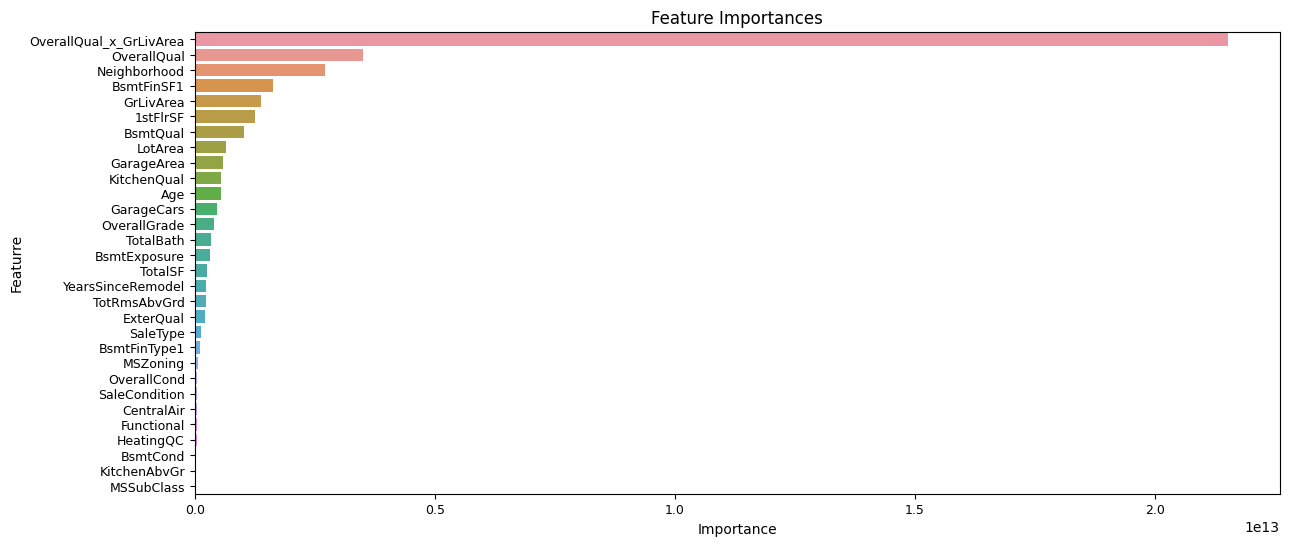

In [443]:
#特徴量の重要度を可視化させている。なお、もってくる特徴量の変数は、モデルの計算用に使用した、x_tr(テストデータ用の説明変数である)
#なお、MSsubclassは 数値型であるが、実質的にはカテゴリ変数のため、その数字に意味を持たないので、重要度が低くなっている。（必ず変換して意味を持たせる必要あり）
imp_df = pd.DataFrame({
    "features": x_tr.columns,
    "imp": model.feature_importances_
})
imp_df = imp_df.sort_values(by="imp", ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x="imp", y="features", data=imp_df.head(30))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Featurre")

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

## **提出用のデータフレームに整形する

In [444]:
#作成したモデルで、x_test を 計算（model.predict(x_test) の部分）し、これを  y_test_pred にいれている。
y_test_pred = model.predict(x_test)

df_submit = pd.DataFrame({
    'Id': test.Id,
    'SalePrice': y_test_pred
})
df_submit.head(10)

,Id,SalePrice
0,1461,130162.285340
1,1462,161700.917302
2,1463,169627.354923
3,1464,182771.796934
4,1465,187478.905057
5,1466,172507.140184
6,1467,181190.336260
7,1468,168373.839756
8,1469,180686.099948
9,1470,131786.482491


## **CSVファイルを出力する。

In [445]:
df_submit.to_csv("hp-submission_toriaeze20250829-2.csv", index=False)

In [446]:
#KitchenAbvG 単体でカテゴリー変換しても、精度は悪くなる可能性がある。（２０２５年６月２４日）